### InceptionV3 モデルのcheckpointを取得する

In [1]:
import sys
import os
import tarfile
from six.moves import urllib
from __future__ import division, print_function, unicode_literals

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [6]:
VOC_URL = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
VOC_DOWNLOAD_PATH = os.path.join('datasets', 'VOC')

def fetch_voc(url = VOC_URL, path = VOC_DOWNLOAD_PATH):
    if os.path.exists(VOC_DOWNLOAD_PATH):
        print()
        return
    os.makedirs(path)
    tgz_path = os.path.join(path, 'VOC_photos.tar')
    urllib.request.urlretrieve(url, tgz_path, reporthook = download_progress)
    voc_tgz = tarfile.open(tgz_path)
    voc_tgz.extractall(path = path)
    voc_tgz.close()
    os.remove(tgz_path)

In [5]:
fetch_pretrained_inception_v3()

Downloading: 100%

In [7]:
fetch_voc()

Downloading: 100%

NameError: global name 'flowers_tgz' is not defined

### 画像のパスを全部取得する

In [2]:
VOC_DATA_HOME = os.path.join(VOC_DOWNLOAD_PATH, 'VOCdevkit', 'VOC2012')

image_paths = list()
annotation_paths = list()

image_dir = os.path.join(VOC_DATA_HOME, 'JPEGImages')
for filepath in os.listdir(image_dir):
    if filepath.endswith('jpg'):
        image_paths.append(os.path.join(image_dir, filepath))
    
annotation_dir = os.path.join(VOC_DATA_HOME, 'Annotations')
for filepath in os.listdir(annotation_dir):
    if filepath.endswith('xml'):
        annotation_paths.append(os.path.join(annotation_dir, filepath))

In [3]:
image_paths.sort()
print(len(image_paths))
print(image_paths[0])
print(image_paths[301])

annotation_paths.sort()
print(len(annotation_paths))
print(annotation_paths[0])
print(annotation_paths[301])

17125
JPEGImages/2007_000027.jpg
JPEGImages/2007_004281.jpg
17125
Annotations/2007_000027.xml
Annotations/2007_004281.xml


### Annotationの.xmlファイルに整数ではないbounding box の値が存在するので、そのようなファイルを探す

In [9]:
from scipy.misc import imresize
from collections import defaultdict
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [18]:
def get_list_with_nonint_bndbox(annotation_paths):
    wrong_xml_paths = []
    for annotation_path in annotation_paths:
        tree = ET.parse(annotation_path)
        try:
            bnd_box_roots = tree.findall('object/bndbox')
            bnd_boxs = [(bnd_box_root.findtext('xmin'), bnd_box_root.findtext('ymin'),
            bnd_box_root.findtext('xmax'), bnd_box_root.findtext('ymax'),) 
            for bnd_box_root in list(bnd_box_roots)]
            
            for i in range(len(bnd_boxs)):
                a_ = int(bnd_boxs[i][0])
                b_ = int(bnd_boxs[i][1])
                c_ = int(bnd_boxs[i][2])
                d_ = int(bnd_boxs[i][3])
        except ValueError:
            wrong_xml_paths.append(annotation_path)
    return wrong_xml_paths

In [19]:
wrong_xml_paths = get_list_with_nonint_bndbox(annotation_paths = annotation_paths)

In [20]:
print(wrong_xml_paths)

['Annotations/2011_006777.xml']


### 画像からRegion proposal部分の画素とラベルと抽出し、InceptionV3の入力次元にresizeする関数の定義

In [4]:
def get_region_proposal_and_label(image_path, annotation_path, target_width = 299, target_height = 299):
    """return a dict of region_proposals 
         the key of which is the object label and 
         the value is a list of the img and the bounding box
         exp: {'person': [(fig1, bnd_box1), (fig2, bnd_box2)]}"""
    
    tree = ET.parse(annotation_path)
    object_names = [object_name.text for object_name in tree.findall('object/name')]
    bnd_box_roots = tree.findall('object/bndbox')
    bnd_boxs = [(bnd_box_root.findtext('xmin'), bnd_box_root.findtext('ymin'),
            bnd_box_root.findtext('xmax'), bnd_box_root.findtext('ymax'),) 
            for bnd_box_root in list(bnd_box_roots)]
    
    region_proposals = defaultdict(list)
    
    img = mpimg.imread(image_path)
    for i in range(len(bnd_boxs)):
        region_proposal = img[int(bnd_boxs[i][1]) : int(bnd_boxs[i][3]), int(bnd_boxs[i][0]) : int(bnd_boxs[i][2])]
        region_proposal = imresize(region_proposal, (target_width, target_height))
        region_proposal = region_proposal.astype(np.float32) / 255
        region_proposals[object_names[i]].append((region_proposal, bnd_boxs[i]))
    
    return region_proposals

In [5]:
region_proposals = get_region_proposal_and_label(image_path = os.path.join('JPEGImages', '2007_000027.jpg'),
                                                annotation_path = os.path.join('Annotations/2007_000027.xml'))
print(type(region_proposals[region_proposals.keys()[0]]))
print(region_proposals[region_proposals.keys()[0]][0][1])

<type 'list'>
('174', '101', '349', '351')


/anaconda3/envs/ai_course/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


### Region Proposal の画像データを新しいディレクトリーに保存し、画像のパスとラベルのリストを返す

In [6]:
voc_class_ids = {'person': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 
                'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'pottedplant': 15, 
                'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [33]:
import datetime
try:
    import cPickle as pickle
except:
    import pickle as pickle

RP_IMAGES_PATH = os.path.join('rpimages')

def save_region_proposal_images(image_paths = image_paths, annotation_paths = annotation_paths):
    for image_path, annotation_path in zip(image_paths, annotation_paths):
        region_proposals = get_region_proposal_and_label(image_path = image_path, 
                                                         annotation_path = annotation_path)
        for label, imgs_with_bndbox in region_proposals.items():
            for img_with_bndbox in imgs_with_bndbox:
                now = datetime.datetime.now()
                filename = '{0:%H%M%f}'.format(now)
                np.save(os.path.join(RP_IMAGES_PATH, filename), img_with_bndbox[0])      #3/5ぐらいで39.8G消費した 
                #with open(os.path.join(RP_IMAGES_PATH, filename), 'wb') as f:      #毎回fileを開く動作が重い
                    #pickle.dump(img_with_bndbox[0].tolist(), f)
                print(image_path)
                
                yield (os.path.join(RP_IMAGES_PATH, filename + '.npy'), voc_class_ids[label])

In [34]:
voc_paths_and_classes = []

if not os.path.exists(RP_IMAGES_PATH):
    os.makedirs(RP_IMAGES_PATH)
    
voc_save_counter = 0
    
for mid_yield in save_region_proposal_images():
    voc_paths_and_classes.append(mid_yield)
    voc_save_counter += 1
    if voc_save_counter >= 100:
        voc_save_counter = 0
        with open('voc_paths_and_classes', 'wb') as f:
            pickle.dump(voc_paths_and_classes, f)
            
with open('voc_paths_and_classes', 'wb') as f:
            pickle.dump(voc_paths_and_classes, f)

/anaconda3/envs/ai_course/lib/python2.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


JPEGImages/2007_000027.jpg
JPEGImages/2007_000032.jpg
JPEGImages/2007_000032.jpg
JPEGImages/2007_000032.jpg
JPEGImages/2007_000032.jpg
JPEGImages/2007_000033.jpg
JPEGImages/2007_000033.jpg
JPEGImages/2007_000033.jpg
JPEGImages/2007_000039.jpg
JPEGImages/2007_000042.jpg
JPEGImages/2007_000042.jpg
JPEGImages/2007_000061.jpg
JPEGImages/2007_000061.jpg
JPEGImages/2007_000063.jpg
JPEGImages/2007_000063.jpg
JPEGImages/2007_000068.jpg
JPEGImages/2007_000121.jpg
JPEGImages/2007_000121.jpg
JPEGImages/2007_000123.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000129.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000170.jpg
JPEGImages/2007_000175.jpg
JPEGImages/2007_000187.jpg
JPEGImages/2007_000241.jpg
JPEGImages/2007_000241.jpg
JPEGImages/2007_000241.jpg
JPEGImages/2007_000243.jpg
J

JPEGImages/2007_001763.jpg
JPEGImages/2007_001763.jpg
JPEGImages/2007_001763.jpg
JPEGImages/2007_001763.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001764.jpg
JPEGImages/2007_001774.jpg
JPEGImages/2007_001825.jpg
JPEGImages/2007_001825.jpg
JPEGImages/2007_001834.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001857.jpg
JPEGImages/2007_001872.jpg
JPEGImages/2007_001884.jpg
JPEGImages/2007_001884.jpg
JPEGImages/2007_001884.jpg
JPEGImages/2007_001884.jpg
JPEGImages/2007_001901.jpg
JPEGImages/2007_001901.jpg
JPEGImages/2007_001901.jpg
JPEGImages/2007_001901.jpg
JPEGImages/2007_001901.jpg
JPEGImages/2007_001917.jpg
JPEGImages/2007_001917.jpg
JPEGImages/2007_001917.jpg
JPEGImages/2007_001955.jpg
JPEGImages/2007_001955.jpg
JPEGImages/2007_001960.jpg
J

JPEGImages/2007_003530.jpg
JPEGImages/2007_003530.jpg
JPEGImages/2007_003541.jpg
JPEGImages/2007_003541.jpg
JPEGImages/2007_003541.jpg
JPEGImages/2007_003565.jpg
JPEGImages/2007_003571.jpg
JPEGImages/2007_003580.jpg
JPEGImages/2007_003581.jpg
JPEGImages/2007_003581.jpg
JPEGImages/2007_003581.jpg
JPEGImages/2007_003587.jpg
JPEGImages/2007_003587.jpg
JPEGImages/2007_003593.jpg
JPEGImages/2007_003593.jpg
JPEGImages/2007_003604.jpg
JPEGImages/2007_003604.jpg
JPEGImages/2007_003611.jpg
JPEGImages/2007_003611.jpg
JPEGImages/2007_003621.jpg
JPEGImages/2007_003621.jpg
JPEGImages/2007_003621.jpg
JPEGImages/2007_003621.jpg
JPEGImages/2007_003659.jpg
JPEGImages/2007_003668.jpg
JPEGImages/2007_003682.jpg
JPEGImages/2007_003682.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003711.jpg
JPEGImages/2007_003714.jpg
JPEGImages/2007_003715.jpg
J

JPEGImages/2007_005273.jpg
JPEGImages/2007_005273.jpg
JPEGImages/2007_005273.jpg
JPEGImages/2007_005273.jpg
JPEGImages/2007_005273.jpg
JPEGImages/2007_005281.jpg
JPEGImages/2007_005281.jpg
JPEGImages/2007_005281.jpg
JPEGImages/2007_005281.jpg
JPEGImages/2007_005281.jpg
JPEGImages/2007_005294.jpg
JPEGImages/2007_005296.jpg
JPEGImages/2007_005296.jpg
JPEGImages/2007_005296.jpg
JPEGImages/2007_005304.jpg
JPEGImages/2007_005304.jpg
JPEGImages/2007_005310.jpg
JPEGImages/2007_005310.jpg
JPEGImages/2007_005314.jpg
JPEGImages/2007_005331.jpg
JPEGImages/2007_005331.jpg
JPEGImages/2007_005331.jpg
JPEGImages/2007_005331.jpg
JPEGImages/2007_005331.jpg
JPEGImages/2007_005354.jpg
JPEGImages/2007_005354.jpg
JPEGImages/2007_005354.jpg
JPEGImages/2007_005354.jpg
JPEGImages/2007_005358.jpg
JPEGImages/2007_005358.jpg
JPEGImages/2007_005360.jpg
JPEGImages/2007_005360.jpg
JPEGImages/2007_005368.jpg
JPEGImages/2007_005368.jpg
JPEGImages/2007_005405.jpg
JPEGImages/2007_005425.jpg
JPEGImages/2007_005425.jpg
J

JPEGImages/2007_006803.jpg
JPEGImages/2007_006803.jpg
JPEGImages/2007_006803.jpg
JPEGImages/2007_006808.jpg
JPEGImages/2007_006809.jpg
JPEGImages/2007_006832.jpg
JPEGImages/2007_006837.jpg
JPEGImages/2007_006837.jpg
JPEGImages/2007_006837.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006841.jpg
JPEGImages/2007_006856.jpg
JPEGImages/2007_006864.jpg
JPEGImages/2007_006864.jpg
JPEGImages/2007_006864.jpg
JPEGImages/2007_006864.jpg
JPEGImages/2007_006865.jpg
JPEGImages/2007_006866.jpg
JPEGImages/2007_006866.jpg
JPEGImages/2007_006866.jpg
JPEGImages/2007_006899.jpg
JPEGImages/2007_006899.jpg
JPEGImages/2007_006899.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006900.jpg
JPEGImages/2007_006901.jpg
JPEGImages/2007_006901.jpg
JPEGImages/2007_006944.jpg
J

JPEGImages/2007_008140.jpg
JPEGImages/2007_008140.jpg
JPEGImages/2007_008142.jpg
JPEGImages/2007_008142.jpg
JPEGImages/2007_008157.jpg
JPEGImages/2007_008157.jpg
JPEGImages/2007_008157.jpg
JPEGImages/2007_008203.jpg
JPEGImages/2007_008203.jpg
JPEGImages/2007_008204.jpg
JPEGImages/2007_008204.jpg
JPEGImages/2007_008204.jpg
JPEGImages/2007_008211.jpg
JPEGImages/2007_008218.jpg
JPEGImages/2007_008218.jpg
JPEGImages/2007_008218.jpg
JPEGImages/2007_008219.jpg
JPEGImages/2007_008219.jpg
JPEGImages/2007_008219.jpg
JPEGImages/2007_008222.jpg
JPEGImages/2007_008256.jpg
JPEGImages/2007_008256.jpg
JPEGImages/2007_008260.jpg
JPEGImages/2007_008260.jpg
JPEGImages/2007_008307.jpg
JPEGImages/2007_008307.jpg
JPEGImages/2007_008321.jpg
JPEGImages/2007_008339.jpg
JPEGImages/2007_008374.jpg
JPEGImages/2007_008374.jpg
JPEGImages/2007_008374.jpg
JPEGImages/2007_008374.jpg
JPEGImages/2007_008396.jpg
JPEGImages/2007_008396.jpg
JPEGImages/2007_008403.jpg
JPEGImages/2007_008407.jpg
JPEGImages/2007_008407.jpg
J

JPEGImages/2007_009724.jpg
JPEGImages/2007_009736.jpg
JPEGImages/2007_009738.jpg
JPEGImages/2007_009750.jpg
JPEGImages/2007_009750.jpg
JPEGImages/2007_009750.jpg
JPEGImages/2007_009750.jpg
JPEGImages/2007_009750.jpg
JPEGImages/2007_009756.jpg
JPEGImages/2007_009756.jpg
JPEGImages/2007_009759.jpg
JPEGImages/2007_009764.jpg
JPEGImages/2007_009764.jpg
JPEGImages/2007_009779.jpg
JPEGImages/2007_009779.jpg
JPEGImages/2007_009779.jpg
JPEGImages/2007_009779.jpg
JPEGImages/2007_009779.jpg
JPEGImages/2007_009783.jpg
JPEGImages/2007_009788.jpg
JPEGImages/2007_009788.jpg
JPEGImages/2007_009794.jpg
JPEGImages/2007_009807.jpg
JPEGImages/2007_009817.jpg
JPEGImages/2007_009832.jpg
JPEGImages/2007_009841.jpg
JPEGImages/2007_009841.jpg
JPEGImages/2007_009889.jpg
JPEGImages/2007_009897.jpg
JPEGImages/2007_009897.jpg
JPEGImages/2007_009899.jpg
JPEGImages/2007_009901.jpg
JPEGImages/2007_009901.jpg
JPEGImages/2007_009901.jpg
JPEGImages/2007_009901.jpg
JPEGImages/2007_009901.jpg
JPEGImages/2007_009901.jpg
J

JPEGImages/2008_000251.jpg
JPEGImages/2008_000251.jpg
JPEGImages/2008_000251.jpg
JPEGImages/2008_000251.jpg
JPEGImages/2008_000252.jpg
JPEGImages/2008_000252.jpg
JPEGImages/2008_000252.jpg
JPEGImages/2008_000252.jpg
JPEGImages/2008_000252.jpg
JPEGImages/2008_000253.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000254.jpg
JPEGImages/2008_000255.jpg
JPEGImages/2008_000257.jpg
JPEGImages/2008_000257.jpg
JPEGImages/2008_000257.jpg
JPEGImages/2008_000257.jpg
JPEGImages/2008_000257.jpg
JPEGImages/2008_000259.jpg
JPEGImages/2008_000259.jpg
JPEGImages/2008_000259.jpg
JPEGImages/2008_000260.jpg
JPEGImages/2008_000260.jpg
JPEGImages/2008_000260.jpg
JPEGImages/2008_000260.jpg
JPEGImages/2008_000260.jpg
JPEGImages/2008_000261.jpg
JPEGImages/2008_000261.jpg
JPEGImages/2008_000261.jpg
JPEGImages/2008_000261.jpg
JPEGImages/2008_000262.jpg
JPEGImages/2008_000264.jpg
J

JPEGImages/2008_000461.jpg
JPEGImages/2008_000461.jpg
JPEGImages/2008_000464.jpg
JPEGImages/2008_000465.jpg
JPEGImages/2008_000465.jpg
JPEGImages/2008_000465.jpg
JPEGImages/2008_000465.jpg
JPEGImages/2008_000465.jpg
JPEGImages/2008_000466.jpg
JPEGImages/2008_000466.jpg
JPEGImages/2008_000469.jpg
JPEGImages/2008_000469.jpg
JPEGImages/2008_000469.jpg
JPEGImages/2008_000470.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000471.jpg
JPEGImages/2008_000472.jpg
JPEGImages/2008_000473.jpg
JPEGImages/2008_000473.jpg
JPEGImages/2008_000473.jpg
JPEGImages/2008_000473.jpg
JPEGImages/2008_000474.jpg
JPEGImages/2008_000475.jpg
JPEGImages/2008_000475.jpg
JPEGImages/2008_000475.jpg
JPEGImages/2008_000480.jpg
JPEGImages/2008_000480.jpg
JPEGImages/2008_000480.jpg
JPEGImages/2008_000480.jpg
JPEGImages/2008_000481.jpg
JPEGImages/2008_000488.jpg
JPEGImages/2008_000488.jpg
JPEGImages/2008_000488.jpg
J

JPEGImages/2008_000734.jpg
JPEGImages/2008_000734.jpg
JPEGImages/2008_000734.jpg
JPEGImages/2008_000737.jpg
JPEGImages/2008_000740.jpg
JPEGImages/2008_000742.jpg
JPEGImages/2008_000742.jpg
JPEGImages/2008_000745.jpg
JPEGImages/2008_000748.jpg
JPEGImages/2008_000748.jpg
JPEGImages/2008_000753.jpg
JPEGImages/2008_000756.jpg
JPEGImages/2008_000756.jpg
JPEGImages/2008_000758.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000760.jpg
JPEGImages/2008_000761.jpg
JPEGImages/2008_000763.jpg
JPEGImages/2008_000763.jpg
JPEGImages/2008_000764.jpg
JPEGImages/2008_000764.jpg
JPEGImages/2008_000765.jpg
JPEGImages/2008_000769.jpg
JPEGImages/2008_000775.jpg
JPEGImages/2008_000775.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
JPEGImages/2008_000776.jpg
J

JPEGImages/2008_000960.jpg
JPEGImages/2008_000960.jpg
JPEGImages/2008_000960.jpg
JPEGImages/2008_000964.jpg
JPEGImages/2008_000964.jpg
JPEGImages/2008_000964.jpg
JPEGImages/2008_000965.jpg
JPEGImages/2008_000965.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000970.jpg
JPEGImages/2008_000971.jpg
JPEGImages/2008_000971.jpg
JPEGImages/2008_000971.jpg
JPEGImages/2008_000972.jpg
JPEGImages/2008_000972.jpg
JPEGImages/2008_000973.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000976.jpg
JPEGImages/2008_000979.jpg
JPEGImages/2008_000979.jpg
JPEGImages/2008_000979.jpg
JPEGImages/2008_000979.jpg
JPEGImages/2008_000981.jpg
JPEGImages/2008_000981.jpg
JPEGImages/2008_000981.jpg
J

JPEGImages/2008_001171.jpg
JPEGImages/2008_001171.jpg
JPEGImages/2008_001171.jpg
JPEGImages/2008_001177.jpg
JPEGImages/2008_001177.jpg
JPEGImages/2008_001182.jpg
JPEGImages/2008_001182.jpg
JPEGImages/2008_001183.jpg
JPEGImages/2008_001183.jpg
JPEGImages/2008_001183.jpg
JPEGImages/2008_001183.jpg
JPEGImages/2008_001183.jpg
JPEGImages/2008_001185.jpg
JPEGImages/2008_001188.jpg
JPEGImages/2008_001189.jpg
JPEGImages/2008_001190.jpg
JPEGImages/2008_001190.jpg
JPEGImages/2008_001192.jpg
JPEGImages/2008_001194.jpg
JPEGImages/2008_001196.jpg
JPEGImages/2008_001196.jpg
JPEGImages/2008_001196.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001199.jpg
JPEGImages/2008_001202.jpg
JPEGImages/2008_001202.jpg
JPEGImages/2008_001202.jpg
JPEGImages/2008_001202.jpg
JPEGImages/2008_001203.jpg
J

JPEGImages/2008_001420.jpg
JPEGImages/2008_001420.jpg
JPEGImages/2008_001420.jpg
JPEGImages/2008_001420.jpg
JPEGImages/2008_001420.jpg
JPEGImages/2008_001420.jpg
JPEGImages/2008_001427.jpg
JPEGImages/2008_001428.jpg
JPEGImages/2008_001429.jpg
JPEGImages/2008_001430.jpg
JPEGImages/2008_001431.jpg
JPEGImages/2008_001431.jpg
JPEGImages/2008_001431.jpg
JPEGImages/2008_001432.jpg
JPEGImages/2008_001432.jpg
JPEGImages/2008_001433.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001434.jpg
JPEGImages/2008_001436.jpg
JPEGImages/2008_001437.jpg
JPEGImages/2008_001437.jpg
JPEGImages/2008_001437.jpg
JPEGImages/2008_001437.jpg
JPEGImages/2008_001437.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001439.jpg
JPEGImages/2008_001440.jpg
J

JPEGImages/2008_001625.jpg
JPEGImages/2008_001626.jpg
JPEGImages/2008_001629.jpg
JPEGImages/2008_001629.jpg
JPEGImages/2008_001629.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001631.jpg
JPEGImages/2008_001632.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001636.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001638.jpg
JPEGImages/2008_001640.jpg
JPEGImages/2008_001641.jpg
J

JPEGImages/2008_001820.jpg
JPEGImages/2008_001820.jpg
JPEGImages/2008_001821.jpg
JPEGImages/2008_001823.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001825.jpg
JPEGImages/2008_001829.jpg
JPEGImages/2008_001830.jpg
JPEGImages/2008_001830.jpg
JPEGImages/2008_001830.jpg
JPEGImages/2008_001832.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001834.jpg
JPEGImages/2008_001836.jpg
JPEGImages/2008_001836.jpg
JPEGImages/2008_001837.jpg
J

JPEGImages/2008_002023.jpg
JPEGImages/2008_002023.jpg
JPEGImages/2008_002026.jpg
JPEGImages/2008_002026.jpg
JPEGImages/2008_002026.jpg
JPEGImages/2008_002026.jpg
JPEGImages/2008_002031.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002032.jpg
JPEGImages/2008_002033.jpg
JPEGImages/2008_002035.jpg
JPEGImages/2008_002036.jpg
JPEGImages/2008_002036.jpg
JPEGImages/2008_002036.jpg
JPEGImages/2008_002036.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002037.jpg
JPEGImages/2008_002039.jpg
JPEGImages/2008_002039.jpg
JPEGImages/2008_002042.jpg
JPEGImages/2008_002042.jpg
JPEGImages/2008_002042.jpg
JPEGImages/2008_002042.jpg
JPEGImages/2008_002043.jpg
JPEGImages/2008_002045.jpg
JPEGImages/2008_002045.jpg
JPEGImages/2008_002046.jpg
J

JPEGImages/2008_002205.jpg
JPEGImages/2008_002206.jpg
JPEGImages/2008_002207.jpg
JPEGImages/2008_002207.jpg
JPEGImages/2008_002207.jpg
JPEGImages/2008_002207.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002208.jpg
JPEGImages/2008_002209.jpg
JPEGImages/2008_002210.jpg
JPEGImages/2008_002210.jpg
JPEGImages/2008_002210.jpg
JPEGImages/2008_002212.jpg
JPEGImages/2008_002212.jpg
JPEGImages/2008_002212.jpg
JPEGImages/2008_002212.jpg
JPEGImages/2008_002215.jpg
JPEGImages/2008_002218.jpg
JPEGImages/2008_002218.jpg
JPEGImages/2008_002218.jpg
JPEGImages/2008_002220.jpg
JPEGImages/2008_002220.jpg
JPEGImages/2008_002220.jpg
JPEGImages/2008_002220.jpg
JPEGImages/2008_002221.jpg
JPEGImages/2008_002222.jpg
JPEGImages/2008_002222.jpg
JPEGImages/2008_002222.jpg
JPEGImages/2008_002222.jpg
JPEGImages/2008_002223.jpg
JPEGImages/2008_002225.jpg
JPEGImages/2008_002225.jpg
JPEGImages/2008_002227.jpg
J

JPEGImages/2008_002411.jpg
JPEGImages/2008_002411.jpg
JPEGImages/2008_002411.jpg
JPEGImages/2008_002411.jpg
JPEGImages/2008_002412.jpg
JPEGImages/2008_002412.jpg
JPEGImages/2008_002414.jpg
JPEGImages/2008_002418.jpg
JPEGImages/2008_002418.jpg
JPEGImages/2008_002419.jpg
JPEGImages/2008_002419.jpg
JPEGImages/2008_002422.jpg
JPEGImages/2008_002422.jpg
JPEGImages/2008_002422.jpg
JPEGImages/2008_002424.jpg
JPEGImages/2008_002425.jpg
JPEGImages/2008_002428.jpg
JPEGImages/2008_002429.jpg
JPEGImages/2008_002430.jpg
JPEGImages/2008_002430.jpg
JPEGImages/2008_002430.jpg
JPEGImages/2008_002430.jpg
JPEGImages/2008_002434.jpg
JPEGImages/2008_002434.jpg
JPEGImages/2008_002434.jpg
JPEGImages/2008_002434.jpg
JPEGImages/2008_002434.jpg
JPEGImages/2008_002436.jpg
JPEGImages/2008_002436.jpg
JPEGImages/2008_002437.jpg
JPEGImages/2008_002438.jpg
JPEGImages/2008_002438.jpg
JPEGImages/2008_002439.jpg
JPEGImages/2008_002441.jpg
JPEGImages/2008_002441.jpg
JPEGImages/2008_002442.jpg
JPEGImages/2008_002442.jpg
J

JPEGImages/2008_002653.jpg
JPEGImages/2008_002653.jpg
JPEGImages/2008_002662.jpg
JPEGImages/2008_002665.jpg
JPEGImages/2008_002665.jpg
JPEGImages/2008_002666.jpg
JPEGImages/2008_002666.jpg
JPEGImages/2008_002668.jpg
JPEGImages/2008_002670.jpg
JPEGImages/2008_002670.jpg
JPEGImages/2008_002670.jpg
JPEGImages/2008_002670.jpg
JPEGImages/2008_002670.jpg
JPEGImages/2008_002672.jpg
JPEGImages/2008_002672.jpg
JPEGImages/2008_002673.jpg
JPEGImages/2008_002673.jpg
JPEGImages/2008_002673.jpg
JPEGImages/2008_002674.jpg
JPEGImages/2008_002674.jpg
JPEGImages/2008_002674.jpg
JPEGImages/2008_002675.jpg
JPEGImages/2008_002675.jpg
JPEGImages/2008_002676.jpg
JPEGImages/2008_002676.jpg
JPEGImages/2008_002676.jpg
JPEGImages/2008_002677.jpg
JPEGImages/2008_002677.jpg
JPEGImages/2008_002678.jpg
JPEGImages/2008_002679.jpg
JPEGImages/2008_002679.jpg
JPEGImages/2008_002679.jpg
JPEGImages/2008_002679.jpg
JPEGImages/2008_002680.jpg
JPEGImages/2008_002681.jpg
JPEGImages/2008_002682.jpg
JPEGImages/2008_002684.jpg
J

JPEGImages/2008_002887.jpg
JPEGImages/2008_002887.jpg
JPEGImages/2008_002887.jpg
JPEGImages/2008_002890.jpg
JPEGImages/2008_002891.jpg
JPEGImages/2008_002891.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002892.jpg
JPEGImages/2008_002894.jpg
JPEGImages/2008_002894.jpg
JPEGImages/2008_002897.jpg
JPEGImages/2008_002897.jpg
JPEGImages/2008_002899.jpg
JPEGImages/2008_002900.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002903.jpg
JPEGImages/2008_002904.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
JPEGImages/2008_002906.jpg
J

JPEGImages/2008_003101.jpg
JPEGImages/2008_003104.jpg
JPEGImages/2008_003105.jpg
JPEGImages/2008_003106.jpg
JPEGImages/2008_003106.jpg
JPEGImages/2008_003106.jpg
JPEGImages/2008_003107.jpg
JPEGImages/2008_003107.jpg
JPEGImages/2008_003108.jpg
JPEGImages/2008_003108.jpg
JPEGImages/2008_003108.jpg
JPEGImages/2008_003108.jpg
JPEGImages/2008_003108.jpg
JPEGImages/2008_003110.jpg
JPEGImages/2008_003110.jpg
JPEGImages/2008_003110.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003112.jpg
JPEGImages/2008_003114.jpg
JPEGImages/2008_003120.jpg
JPEGImages/2008_003120.jpg
JPEGImages/2008_003122.jpg
JPEGImages/2008_003127.jpg
JPEGImages/2008_003128.jpg
JPEGImages/2008_003128.jpg
JPEGImages/2008_003132.jpg
JPEGImages/2008_003132.jpg
JPEGImages/2008_003132.jpg
JPEGImages/2008_003132.jpg
JPEGImages/2008_003133.jpg
JPEGImages/2008_003133.jpg
J

JPEGImages/2008_003323.jpg
JPEGImages/2008_003323.jpg
JPEGImages/2008_003326.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003329.jpg
JPEGImages/2008_003330.jpg
JPEGImages/2008_003331.jpg
JPEGImages/2008_003333.jpg
JPEGImages/2008_003333.jpg
JPEGImages/2008_003333.jpg
JPEGImages/2008_003334.jpg
JPEGImages/2008_003334.jpg
JPEGImages/2008_003335.jpg
JPEGImages/2008_003335.jpg
JPEGImages/2008_003336.jpg
JPEGImages/2008_003336.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003338.jpg
JPEGImages/2008_003342.jpg
JPEGImages/2008_003342.jpg
JPEGImages/2008_003342.jpg
J

JPEGImages/2008_003572.jpg
JPEGImages/2008_003572.jpg
JPEGImages/2008_003572.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003575.jpg
JPEGImages/2008_003576.jpg
JPEGImages/2008_003577.jpg
JPEGImages/2008_003577.jpg
JPEGImages/2008_003578.jpg
JPEGImages/2008_003578.jpg
JPEGImages/2008_003578.jpg
JPEGImages/2008_003578.jpg
JPEGImages/2008_003578.jpg
JPEGImages/2008_003579.jpg
JPEGImages/2008_003579.jpg
JPEGImages/2008_003579.jpg
JPEGImages/2008_003579.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003580.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003582.jpg
JPEGImages/2008_003585.jpg
JPEGImages/2008_003587.jpg
JPEGImages/2008_003587.jpg
J

JPEGImages/2008_003779.jpg
JPEGImages/2008_003779.jpg
JPEGImages/2008_003779.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003780.jpg
JPEGImages/2008_003781.jpg
JPEGImages/2008_003781.jpg
JPEGImages/2008_003781.jpg
JPEGImages/2008_003781.jpg
JPEGImages/2008_003781.jpg
JPEGImages/2008_003782.jpg
JPEGImages/2008_003788.jpg
JPEGImages/2008_003789.jpg
JPEGImages/2008_003789.jpg
JPEGImages/2008_003791.jpg
JPEGImages/2008_003791.jpg
JPEGImages/2008_003791.jpg
JPEGImages/2008_003793.jpg
JPEGImages/2008_003793.jpg
JPEGImages/2008_003793.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003794.jpg
JPEGImages/2008_003796.jpg
JPEGImages/2008_003796.jpg
JPEGImages/2008_003796.jpg
JPEGImages/2008_003796.jpg
JPEGImages/2008_003796.jpg
JPEGImages/2008_003796.jpg
J

JPEGImages/2008_003986.jpg
JPEGImages/2008_003988.jpg
JPEGImages/2008_003988.jpg
JPEGImages/2008_003988.jpg
JPEGImages/2008_003989.jpg
JPEGImages/2008_003992.jpg
JPEGImages/2008_003992.jpg
JPEGImages/2008_003992.jpg
JPEGImages/2008_003992.jpg
JPEGImages/2008_003995.jpg
JPEGImages/2008_003995.jpg
JPEGImages/2008_003995.jpg
JPEGImages/2008_003995.jpg
JPEGImages/2008_003995.jpg
JPEGImages/2008_003996.jpg
JPEGImages/2008_003997.jpg
JPEGImages/2008_003998.jpg
JPEGImages/2008_003998.jpg
JPEGImages/2008_004000.jpg
JPEGImages/2008_004000.jpg
JPEGImages/2008_004000.jpg
JPEGImages/2008_004002.jpg
JPEGImages/2008_004002.jpg
JPEGImages/2008_004002.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004003.jpg
JPEGImages/2008_004004.jpg
JPEGImages/2008_004006.jpg
J

JPEGImages/2008_004243.jpg
JPEGImages/2008_004245.jpg
JPEGImages/2008_004245.jpg
JPEGImages/2008_004245.jpg
JPEGImages/2008_004245.jpg
JPEGImages/2008_004245.jpg
JPEGImages/2008_004246.jpg
JPEGImages/2008_004246.jpg
JPEGImages/2008_004247.jpg
JPEGImages/2008_004247.jpg
JPEGImages/2008_004247.jpg
JPEGImages/2008_004247.jpg
JPEGImages/2008_004251.jpg
JPEGImages/2008_004251.jpg
JPEGImages/2008_004257.jpg
JPEGImages/2008_004258.jpg
JPEGImages/2008_004259.jpg
JPEGImages/2008_004263.jpg
JPEGImages/2008_004263.jpg
JPEGImages/2008_004263.jpg
JPEGImages/2008_004263.jpg
JPEGImages/2008_004265.jpg
JPEGImages/2008_004269.jpg
JPEGImages/2008_004269.jpg
JPEGImages/2008_004269.jpg
JPEGImages/2008_004270.jpg
JPEGImages/2008_004270.jpg
JPEGImages/2008_004270.jpg
JPEGImages/2008_004271.jpg
JPEGImages/2008_004273.jpg
JPEGImages/2008_004274.jpg
JPEGImages/2008_004276.jpg
JPEGImages/2008_004278.jpg
JPEGImages/2008_004278.jpg
JPEGImages/2008_004278.jpg
JPEGImages/2008_004278.jpg
JPEGImages/2008_004279.jpg
J

JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004457.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004458.jpg
JPEGImages/2008_004459.jpg
JPEGImages/2008_004459.jpg
JPEGImages/2008_004459.jpg
JPEGImages/2008_004460.jpg
JPEGImages/2008_004460.jpg
JPEGImages/2008_004460.jpg
JPEGImages/2008_004460.jpg
JPEGImages/2008_004462.jpg
JPEGImages/2008_004464.jpg
JPEGImages/2008_004464.jpg
JPEGImages/2008_004464.jpg
JPEGImages/2008_004469.jpg
JPEGImages/2008_004469.jpg
JPEGImages/2008_004469.jpg
J

JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004648.jpg
JPEGImages/2008_004649.jpg
JPEGImages/2008_004649.jpg
JPEGImages/2008_004653.jpg
JPEGImages/2008_004654.jpg
JPEGImages/2008_004654.jpg
JPEGImages/2008_004656.jpg
JPEGImages/2008_004656.jpg
JPEGImages/2008_004659.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004661.jpg
JPEGImages/2008_004662.jpg
JPEGImages/2008_004662.jpg
JPEGImages/2008_004662.jpg
JPEGImages/2008_004663.jpg
JPEGImages/2008_004665.jpg
J

JPEGImages/2008_004874.jpg
JPEGImages/2008_004874.jpg
JPEGImages/2008_004874.jpg
JPEGImages/2008_004874.jpg
JPEGImages/2008_004875.jpg
JPEGImages/2008_004875.jpg
JPEGImages/2008_004875.jpg
JPEGImages/2008_004876.jpg
JPEGImages/2008_004881.jpg
JPEGImages/2008_004881.jpg
JPEGImages/2008_004881.jpg
JPEGImages/2008_004881.jpg
JPEGImages/2008_004881.jpg
JPEGImages/2008_004885.jpg
JPEGImages/2008_004887.jpg
JPEGImages/2008_004887.jpg
JPEGImages/2008_004887.jpg
JPEGImages/2008_004887.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004892.jpg
JPEGImages/2008_004893.jpg
JPEGImages/2008_004894.jpg
JPEGImages/2008_004894.jpg
JPEGImages/2008_004894.jpg
JPEGImages/2008_004896.jpg
JPEGImages/2008_004898.jpg
JPEGImages/2008_004898.jpg
J

JPEGImages/2008_005094.jpg
JPEGImages/2008_005094.jpg
JPEGImages/2008_005094.jpg
JPEGImages/2008_005096.jpg
JPEGImages/2008_005097.jpg
JPEGImages/2008_005097.jpg
JPEGImages/2008_005097.jpg
JPEGImages/2008_005097.jpg
JPEGImages/2008_005098.jpg
JPEGImages/2008_005098.jpg
JPEGImages/2008_005101.jpg
JPEGImages/2008_005101.jpg
JPEGImages/2008_005101.jpg
JPEGImages/2008_005105.jpg
JPEGImages/2008_005107.jpg
JPEGImages/2008_005107.jpg
JPEGImages/2008_005108.jpg
JPEGImages/2008_005109.jpg
JPEGImages/2008_005110.jpg
JPEGImages/2008_005110.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005111.jpg
JPEGImages/2008_005114.jpg
JPEGImages/2008_005115.jpg
JPEGImages/2008_005117.jpg
JPEGImages/2008_005123.jpg
JPEGImages/2008_005127.jpg
JPEGImages/2008_005132.jpg
JPEGImages/2008_005132.jpg
JPEGImages/2008_005132.jpg
JPEGImages/2008_005132.jpg
J

JPEGImages/2008_005303.jpg
JPEGImages/2008_005304.jpg
JPEGImages/2008_005304.jpg
JPEGImages/2008_005309.jpg
JPEGImages/2008_005310.jpg
JPEGImages/2008_005313.jpg
JPEGImages/2008_005313.jpg
JPEGImages/2008_005315.jpg
JPEGImages/2008_005315.jpg
JPEGImages/2008_005315.jpg
JPEGImages/2008_005316.jpg
JPEGImages/2008_005316.jpg
JPEGImages/2008_005316.jpg
JPEGImages/2008_005316.jpg
JPEGImages/2008_005319.jpg
JPEGImages/2008_005319.jpg
JPEGImages/2008_005321.jpg
JPEGImages/2008_005323.jpg
JPEGImages/2008_005323.jpg
JPEGImages/2008_005323.jpg
JPEGImages/2008_005323.jpg
JPEGImages/2008_005323.jpg
JPEGImages/2008_005324.jpg
JPEGImages/2008_005324.jpg
JPEGImages/2008_005324.jpg
JPEGImages/2008_005324.jpg
JPEGImages/2008_005325.jpg
JPEGImages/2008_005327.jpg
JPEGImages/2008_005329.jpg
JPEGImages/2008_005329.jpg
JPEGImages/2008_005331.jpg
JPEGImages/2008_005333.jpg
JPEGImages/2008_005333.jpg
JPEGImages/2008_005335.jpg
JPEGImages/2008_005336.jpg
JPEGImages/2008_005336.jpg
JPEGImages/2008_005336.jpg
J

JPEGImages/2008_005549.jpg
JPEGImages/2008_005549.jpg
JPEGImages/2008_005550.jpg
JPEGImages/2008_005552.jpg
JPEGImages/2008_005552.jpg
JPEGImages/2008_005553.jpg
JPEGImages/2008_005553.jpg
JPEGImages/2008_005553.jpg
JPEGImages/2008_005558.jpg
JPEGImages/2008_005558.jpg
JPEGImages/2008_005560.jpg
JPEGImages/2008_005560.jpg
JPEGImages/2008_005560.jpg
JPEGImages/2008_005560.jpg
JPEGImages/2008_005561.jpg
JPEGImages/2008_005561.jpg
JPEGImages/2008_005563.jpg
JPEGImages/2008_005563.jpg
JPEGImages/2008_005564.jpg
JPEGImages/2008_005564.jpg
JPEGImages/2008_005566.jpg
JPEGImages/2008_005566.jpg
JPEGImages/2008_005567.jpg
JPEGImages/2008_005567.jpg
JPEGImages/2008_005569.jpg
JPEGImages/2008_005569.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
JPEGImages/2008_005570.jpg
J

JPEGImages/2008_005779.jpg
JPEGImages/2008_005779.jpg
JPEGImages/2008_005779.jpg
JPEGImages/2008_005779.jpg
JPEGImages/2008_005779.jpg
JPEGImages/2008_005779.jpg
JPEGImages/2008_005780.jpg
JPEGImages/2008_005780.jpg
JPEGImages/2008_005780.jpg
JPEGImages/2008_005788.jpg
JPEGImages/2008_005788.jpg
JPEGImages/2008_005788.jpg
JPEGImages/2008_005790.jpg
JPEGImages/2008_005790.jpg
JPEGImages/2008_005791.jpg
JPEGImages/2008_005791.jpg
JPEGImages/2008_005792.jpg
JPEGImages/2008_005792.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005794.jpg
JPEGImages/2008_005796.jpg
J

JPEGImages/2008_005989.jpg
JPEGImages/2008_005991.jpg
JPEGImages/2008_005991.jpg
JPEGImages/2008_005997.jpg
JPEGImages/2008_006000.jpg
JPEGImages/2008_006000.jpg
JPEGImages/2008_006000.jpg
JPEGImages/2008_006002.jpg
JPEGImages/2008_006002.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006004.jpg
JPEGImages/2008_006007.jpg
JPEGImages/2008_006007.jpg
JPEGImages/2008_006008.jpg
JPEGImages/2008_006008.jpg
JPEGImages/2008_006008.jpg
JPEGImages/2008_006008.jpg
JPEGImages/2008_006010.jpg
JPEGImages/2008_006010.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006014.jpg
JPEGImages/2008_006017.jpg
JPEGImages/2008_006017.jpg
JPEGImages/2008_006020.jpg
JPEGImages/2008_006021.jpg
JPEGImages/2008_006021.jpg
JPEGImages/2008_006024.jpg
JPEGImages/2008_006024.jpg
JPEGImages/2008_006024.jpg
J

JPEGImages/2008_006190.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006192.jpg
JPEGImages/2008_006194.jpg
JPEGImages/2008_006195.jpg
JPEGImages/2008_006195.jpg
JPEGImages/2008_006200.jpg
JPEGImages/2008_006200.jpg
JPEGImages/2008_006200.jpg
JPEGImages/2008_006200.jpg
JPEGImages/2008_006203.jpg
JPEGImages/2008_006203.jpg
JPEGImages/2008_006205.jpg
JPEGImages/2008_006205.jpg
JPEGImages/2008_006207.jpg
JPEGImages/2008_006207.jpg
JPEGImages/2008_006210.jpg
JPEGImages/2008_006210.jpg
JPEGImages/2008_006211.jpg
JPEGImages/2008_006213.jpg
JPEGImages/2008_006215.jpg
JPEGImages/2008_006215.jpg
JPEGImages/2008_006215.jpg
JPEGImages/2008_006215.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006216.jpg
JPEGImages/2008_006218.jpg
JPEGImages/2008_006219.jpg
J

JPEGImages/2008_006410.jpg
JPEGImages/2008_006410.jpg
JPEGImages/2008_006410.jpg
JPEGImages/2008_006416.jpg
JPEGImages/2008_006417.jpg
JPEGImages/2008_006417.jpg
JPEGImages/2008_006417.jpg
JPEGImages/2008_006419.jpg
JPEGImages/2008_006421.jpg
JPEGImages/2008_006421.jpg
JPEGImages/2008_006424.jpg
JPEGImages/2008_006424.jpg
JPEGImages/2008_006424.jpg
JPEGImages/2008_006425.jpg
JPEGImages/2008_006425.jpg
JPEGImages/2008_006425.jpg
JPEGImages/2008_006427.jpg
JPEGImages/2008_006429.jpg
JPEGImages/2008_006429.jpg
JPEGImages/2008_006430.jpg
JPEGImages/2008_006432.jpg
JPEGImages/2008_006433.jpg
JPEGImages/2008_006433.jpg
JPEGImages/2008_006433.jpg
JPEGImages/2008_006434.jpg
JPEGImages/2008_006436.jpg
JPEGImages/2008_006436.jpg
JPEGImages/2008_006436.jpg
JPEGImages/2008_006438.jpg
JPEGImages/2008_006438.jpg
JPEGImages/2008_006438.jpg
JPEGImages/2008_006438.jpg
JPEGImages/2008_006438.jpg
JPEGImages/2008_006441.jpg
JPEGImages/2008_006441.jpg
JPEGImages/2008_006441.jpg
JPEGImages/2008_006447.jpg
J

JPEGImages/2008_006629.jpg
JPEGImages/2008_006631.jpg
JPEGImages/2008_006631.jpg
JPEGImages/2008_006634.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006635.jpg
JPEGImages/2008_006637.jpg
JPEGImages/2008_006638.jpg
JPEGImages/2008_006638.jpg
JPEGImages/2008_006638.jpg
JPEGImages/2008_006638.jpg
JPEGImages/2008_006638.jpg
JPEGImages/2008_006641.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006642.jpg
JPEGImages/2008_006645.jpg
JPEGImages/2008_006646.jpg
JPEGImages/2008_006646.jpg
JPEGImages/2008_006649.jpg
JPEGImages/2008_006650.jpg
JPEGImages/2008_006650.jpg
JPEGImages/2008_006650.jpg
JPEGImages/2008_006654.jpg
JPEGImages/2008_006655.jpg
JPEGImages/2008_006656.jpg
JPEGImages/2008_006657.jpg
JPEGImages/2008_006657.jpg
JPEGImages/2008_006657.jpg
J

JPEGImages/2008_006870.jpg
JPEGImages/2008_006870.jpg
JPEGImages/2008_006872.jpg
JPEGImages/2008_006872.jpg
JPEGImages/2008_006872.jpg
JPEGImages/2008_006872.jpg
JPEGImages/2008_006872.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006873.jpg
JPEGImages/2008_006874.jpg
JPEGImages/2008_006874.jpg
JPEGImages/2008_006874.jpg
JPEGImages/2008_006877.jpg
JPEGImages/2008_006879.jpg
JPEGImages/2008_006879.jpg
JPEGImages/2008_006880.jpg
JPEGImages/2008_006880.jpg
JPEGImages/2008_006880.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006881.jpg
JPEGImages/2008_006882.jpg
JPEGImages/2008_006885.jpg
JPEGImages/2008_006887.jpg
JPEGImages/2008_006887.jpg
JPEGImages/2008_006889.jpg
JPEGImages/2008_006890.jpg
JPEGImages/2008_006890.jpg
J

JPEGImages/2008_007070.jpg
JPEGImages/2008_007070.jpg
JPEGImages/2008_007070.jpg
JPEGImages/2008_007070.jpg
JPEGImages/2008_007070.jpg
JPEGImages/2008_007073.jpg
JPEGImages/2008_007073.jpg
JPEGImages/2008_007075.jpg
JPEGImages/2008_007075.jpg
JPEGImages/2008_007075.jpg
JPEGImages/2008_007076.jpg
JPEGImages/2008_007081.jpg
JPEGImages/2008_007082.jpg
JPEGImages/2008_007084.jpg
JPEGImages/2008_007084.jpg
JPEGImages/2008_007084.jpg
JPEGImages/2008_007085.jpg
JPEGImages/2008_007085.jpg
JPEGImages/2008_007086.jpg
JPEGImages/2008_007086.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007090.jpg
JPEGImages/2008_007091.jpg
JPEGImages/2008_007091.jpg
JPEGImages/2008_007091.jpg
JPEGImages/2008_007095.jpg
JPEGImages/2008_007096.jpg
JPEGImages/2008_007096.jpg
JPEGImages/2008_007097.jpg
J

JPEGImages/2008_007261.jpg
JPEGImages/2008_007261.jpg
JPEGImages/2008_007261.jpg
JPEGImages/2008_007261.jpg
JPEGImages/2008_007261.jpg
JPEGImages/2008_007261.jpg
JPEGImages/2008_007264.jpg
JPEGImages/2008_007264.jpg
JPEGImages/2008_007265.jpg
JPEGImages/2008_007266.jpg
JPEGImages/2008_007269.jpg
JPEGImages/2008_007273.jpg
JPEGImages/2008_007273.jpg
JPEGImages/2008_007274.jpg
JPEGImages/2008_007277.jpg
JPEGImages/2008_007277.jpg
JPEGImages/2008_007279.jpg
JPEGImages/2008_007280.jpg
JPEGImages/2008_007280.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007281.jpg
JPEGImages/2008_007282.jpg
JPEGImages/2008_007282.jpg
JPEGImages/2008_007282.jpg
JPEGImages/2008_007285.jpg
JPEGImages/2008_007285.jpg
JPEGImages/2008_007286.jpg
JPEGImages/2008_007286.jpg
JPEGImages/2008_007286.jpg
JPEGImages/2008_007287.jpg
JPEGImages/2008_007287.jpg
JPEGImages/2008_007287.jpg
J

JPEGImages/2008_007478.jpg
JPEGImages/2008_007478.jpg
JPEGImages/2008_007478.jpg
JPEGImages/2008_007480.jpg
JPEGImages/2008_007480.jpg
JPEGImages/2008_007480.jpg
JPEGImages/2008_007485.jpg
JPEGImages/2008_007485.jpg
JPEGImages/2008_007486.jpg
JPEGImages/2008_007486.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007488.jpg
JPEGImages/2008_007491.jpg
JPEGImages/2008_007494.jpg
JPEGImages/2008_007494.jpg
JPEGImages/2008_007496.jpg
JPEGImages/2008_007497.jpg
JPEGImages/2008_007498.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007500.jpg
JPEGImages/2008_007501.jpg
JPEGImages/2008_007504.jpg
JPEGImages/2008_007507.jpg
JPEGImages/2008_007509.jpg
JPEGImages/2008_007509.jpg
JPEGImages/2008_007510.jpg
JPEGImages/2008_007510.jpg
J

JPEGImages/2008_007683.jpg
JPEGImages/2008_007685.jpg
JPEGImages/2008_007685.jpg
JPEGImages/2008_007685.jpg
JPEGImages/2008_007685.jpg
JPEGImages/2008_007688.jpg
JPEGImages/2008_007690.jpg
JPEGImages/2008_007691.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007692.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007693.jpg
JPEGImages/2008_007694.jpg
J

JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007890.jpg
JPEGImages/2008_007891.jpg
JPEGImages/2008_007893.jpg
JPEGImages/2008_007895.jpg
JPEGImages/2008_007895.jpg
JPEGImages/2008_007897.jpg
JPEGImages/2008_007897.jpg
JPEGImages/2008_007897.jpg
JPEGImages/2008_007902.jpg
JPEGImages/2008_007902.jpg
JPEGImages/2008_007902.jpg
JPEGImages/2008_007902.jpg
JPEGImages/2008_007902.jpg
JPEGImages/2008_007904.jpg
JPEGImages/2008_007907.jpg
JPEGImages/2008_007909.jpg
JPEGImages/2008_007912.jpg
JPEGImages/2008_007913.jpg
JPEGImages/2008_007913.jpg
JPEGImages/2008_007913.jpg
J

JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008096.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008097.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008098.jpg
JPEGImages/2008_008103.jpg
JPEGImages/2008_008105.jpg
JPEGImages/2008_008106.jpg
JPEGImages/2008_008109.jpg
JPEGImages/2008_008109.jpg
JPEGImages/2008_008112.jpg
J

JPEGImages/2008_008337.jpg
JPEGImages/2008_008337.jpg
JPEGImages/2008_008338.jpg
JPEGImages/2008_008338.jpg
JPEGImages/2008_008338.jpg
JPEGImages/2008_008341.jpg
JPEGImages/2008_008341.jpg
JPEGImages/2008_008342.jpg
JPEGImages/2008_008342.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008343.jpg
JPEGImages/2008_008344.jpg
JPEGImages/2008_008345.jpg
JPEGImages/2008_008345.jpg
JPEGImages/2008_008346.jpg
JPEGImages/2008_008347.jpg
JPEGImages/2008_008347.jpg
JPEGImages/2008_008347.jpg
JPEGImages/2008_008347.jpg
JPEGImages/2008_008347.jpg
JPEGImages/2008_008354.jpg
JPEGImages/2008_008356.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
JPEGImages/2008_008357.jpg
J

JPEGImages/2008_008527.jpg
JPEGImages/2008_008527.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008528.jpg
JPEGImages/2008_008530.jpg
JPEGImages/2008_008530.jpg
JPEGImages/2008_008531.jpg
JPEGImages/2008_008531.jpg
JPEGImages/2008_008533.jpg
JPEGImages/2008_008536.jpg
JPEGImages/2008_008537.jpg
JPEGImages/2008_008538.jpg
JPEGImages/2008_008538.jpg
JPEGImages/2008_008541.jpg
JPEGImages/2008_008544.jpg
JPEGImages/2008_008545.jpg
JPEGImages/2008_008546.jpg
JPEGImages/2008_008547.jpg
JPEGImages/2008_008547.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
JPEGImages/2008_008549.jpg
J

JPEGImages/2008_008755.jpg
JPEGImages/2008_008755.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008757.jpg
JPEGImages/2008_008758.jpg
JPEGImages/2008_008758.jpg
JPEGImages/2008_008765.jpg
JPEGImages/2008_008767.jpg
JPEGImages/2008_008770.jpg
JPEGImages/2008_008770.jpg
JPEGImages/2008_008770.jpg
JPEGImages/2008_008772.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2008_008773.jpg
JPEGImages/2009_000001.jpg
JPEGImages/2009_000001.jpg
JPEGImages/2009_000002.jpg
JPEGImages/2009_000002.jpg
JPEGImages/2009_000006.jpg
JPEGImages/2009_000009.jpg
JPEGImages/2009_000009.jpg
JPEGImages/2009_000009.jpg
JPEGImages/2009_000010.jpg
J

JPEGImages/2009_000212.jpg
JPEGImages/2009_000214.jpg
JPEGImages/2009_000214.jpg
JPEGImages/2009_000214.jpg
JPEGImages/2009_000216.jpg
JPEGImages/2009_000217.jpg
JPEGImages/2009_000217.jpg
JPEGImages/2009_000217.jpg
JPEGImages/2009_000217.jpg
JPEGImages/2009_000218.jpg
JPEGImages/2009_000218.jpg
JPEGImages/2009_000219.jpg
JPEGImages/2009_000219.jpg
JPEGImages/2009_000219.jpg
JPEGImages/2009_000223.jpg
JPEGImages/2009_000223.jpg
JPEGImages/2009_000223.jpg
JPEGImages/2009_000223.jpg
JPEGImages/2009_000223.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000225.jpg
JPEGImages/2009_000227.jpg
JPEGImages/2009_000229.jpg
JPEGImages/2009_000232.jpg
JPEGImages/2009_000232.jpg
JPEGImages/2009_000233.jpg
JPEGImages/2009_000237.jpg
JPEGImages/2009_000237.jpg
JPEGImages/2009_000237.jpg
JPEGImages/2009_000237.jpg
J

JPEGImages/2009_000466.jpg
JPEGImages/2009_000469.jpg
JPEGImages/2009_000469.jpg
JPEGImages/2009_000471.jpg
JPEGImages/2009_000471.jpg
JPEGImages/2009_000472.jpg
JPEGImages/2009_000474.jpg
JPEGImages/2009_000474.jpg
JPEGImages/2009_000474.jpg
JPEGImages/2009_000476.jpg
JPEGImages/2009_000476.jpg
JPEGImages/2009_000477.jpg
JPEGImages/2009_000477.jpg
JPEGImages/2009_000483.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000486.jpg
JPEGImages/2009_000487.jpg
JPEGImages/2009_000488.jpg
JPEGImages/2009_000488.jpg
JPEGImages/2009_000488.jpg
JPEGImages/2009_000491.jpg
JPEGImages/2009_000493.jpg
JPEGImages/2009_000494.jpg
JPEGImages/2009_000496.jpg
JPEGImages/2009_000496.jpg
JPEGImages/2009_000496.jpg
JPEGImages/2009_000499.jpg
JPEGImages/2009_000499.jpg
JPEGImages/2009_000500.jpg
J

JPEGImages/2009_000722.jpg
JPEGImages/2009_000722.jpg
JPEGImages/2009_000722.jpg
JPEGImages/2009_000722.jpg
JPEGImages/2009_000723.jpg
JPEGImages/2009_000724.jpg
JPEGImages/2009_000724.jpg
JPEGImages/2009_000725.jpg
JPEGImages/2009_000725.jpg
JPEGImages/2009_000725.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000726.jpg
JPEGImages/2009_000727.jpg
JPEGImages/2009_000727.jpg
JPEGImages/2009_000730.jpg
JPEGImages/2009_000730.jpg
JPEGImages/2009_000731.jpg
JPEGImages/2009_000732.jpg
JPEGImages/2009_000734.jpg
JPEGImages/2009_000737.jpg
JPEGImages/2009_000741.jpg
JPEGImages/2009_000741.jpg
JPEGImages/2009_000741.jpg
JPEGImages/2009_000742.jpg
JPEGImages/2009_000744.jpg
JPEGImages/2009_000745.jpg
JPEGImages/2009_000746.jpg
J

JPEGImages/2009_001002.jpg
JPEGImages/2009_001002.jpg
JPEGImages/2009_001002.jpg
JPEGImages/2009_001006.jpg
JPEGImages/2009_001007.jpg
JPEGImages/2009_001008.jpg
JPEGImages/2009_001009.jpg
JPEGImages/2009_001009.jpg
JPEGImages/2009_001009.jpg
JPEGImages/2009_001009.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001011.jpg
JPEGImages/2009_001012.jpg
JPEGImages/2009_001013.jpg
JPEGImages/2009_001013.jpg
JPEGImages/2009_001016.jpg
JPEGImages/2009_001019.jpg
JPEGImages/2009_001019.jpg
JPEGImages/2009_001019.jpg
JPEGImages/2009_001019.jpg
JPEGImages/2009_001019.jpg
JPEGImages/2009_001021.jpg
JPEGImages/2009_001021.jpg
JPEGImages/2009_001021.jpg
JPEGImages/2009_001021.jpg
JPEGImages/2009_001024.jpg
JPEGImages/2009_001024.jpg
JPEGImages/2009_001024.jpg
JPEGImages/2009_001026.jpg
JPEGImages/2009_001026.jpg
JPEGImages/2009_001026.jpg
JPEGImages/2009_001026.jpg
JPEGImages/2009_001026.jpg
J

JPEGImages/2009_001240.jpg
JPEGImages/2009_001241.jpg
JPEGImages/2009_001241.jpg
JPEGImages/2009_001242.jpg
JPEGImages/2009_001243.jpg
JPEGImages/2009_001243.jpg
JPEGImages/2009_001245.jpg
JPEGImages/2009_001245.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001249.jpg
JPEGImages/2009_001251.jpg
JPEGImages/2009_001252.jpg
JPEGImages/2009_001252.jpg
JPEGImages/2009_001253.jpg
JPEGImages/2009_001254.jpg
JPEGImages/2009_001255.jpg
JPEGImages/2009_001255.jpg
JPEGImages/2009_001255.jpg
JPEGImages/2009_001257.jpg
JPEGImages/2009_001259.jpg
JPEGImages/2009_001260.jpg
JPEGImages/2009_001263.jpg
JPEGImages/2009_001263.jpg
JPEGImages/2009_001263.jpg
JPEGImages/2009_001263.jpg
JPEGImages/2009_001263.jpg
JPEGImages/2009_001263.jpg
J

JPEGImages/2009_001475.jpg
JPEGImages/2009_001476.jpg
JPEGImages/2009_001479.jpg
JPEGImages/2009_001480.jpg
JPEGImages/2009_001480.jpg
JPEGImages/2009_001481.jpg
JPEGImages/2009_001481.jpg
JPEGImages/2009_001484.jpg
JPEGImages/2009_001490.jpg
JPEGImages/2009_001493.jpg
JPEGImages/2009_001493.jpg
JPEGImages/2009_001494.jpg
JPEGImages/2009_001498.jpg
JPEGImages/2009_001500.jpg
JPEGImages/2009_001500.jpg
JPEGImages/2009_001500.jpg
JPEGImages/2009_001500.jpg
JPEGImages/2009_001501.jpg
JPEGImages/2009_001502.jpg
JPEGImages/2009_001505.jpg
JPEGImages/2009_001505.jpg
JPEGImages/2009_001505.jpg
JPEGImages/2009_001505.jpg
JPEGImages/2009_001507.jpg
JPEGImages/2009_001507.jpg
JPEGImages/2009_001508.jpg
JPEGImages/2009_001508.jpg
JPEGImages/2009_001508.jpg
JPEGImages/2009_001508.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
JPEGImages/2009_001509.jpg
J

JPEGImages/2009_001738.jpg
JPEGImages/2009_001738.jpg
JPEGImages/2009_001740.jpg
JPEGImages/2009_001741.jpg
JPEGImages/2009_001743.jpg
JPEGImages/2009_001743.jpg
JPEGImages/2009_001743.jpg
JPEGImages/2009_001743.jpg
JPEGImages/2009_001744.jpg
JPEGImages/2009_001746.jpg
JPEGImages/2009_001747.jpg
JPEGImages/2009_001747.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001749.jpg
JPEGImages/2009_001750.jpg
JPEGImages/2009_001750.jpg
JPEGImages/2009_001750.jpg
JPEGImages/2009_001750.jpg
JPEGImages/2009_001751.jpg
JPEGImages/2009_001752.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001754.jpg
JPEGImages/2009_001755.jpg
JPEGImages/2009_001758.jpg
JPEGImages/2009_001758.jpg
JPEGImages/2009_001758.jpg
J

JPEGImages/2009_001977.jpg
JPEGImages/2009_001977.jpg
JPEGImages/2009_001977.jpg
JPEGImages/2009_001977.jpg
JPEGImages/2009_001979.jpg
JPEGImages/2009_001979.jpg
JPEGImages/2009_001979.jpg
JPEGImages/2009_001980.jpg
JPEGImages/2009_001984.jpg
JPEGImages/2009_001984.jpg
JPEGImages/2009_001984.jpg
JPEGImages/2009_001988.jpg
JPEGImages/2009_001990.jpg
JPEGImages/2009_001990.jpg
JPEGImages/2009_001990.jpg
JPEGImages/2009_001990.jpg
JPEGImages/2009_001990.jpg
JPEGImages/2009_001991.jpg
JPEGImages/2009_001994.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001997.jpg
JPEGImages/2009_001999.jpg
JPEGImages/2009_001999.jpg
JPEGImages/2009_002000.jpg
JPEGImages/2009_002001.jpg
JPEGImages/2009_002001.jpg
JPEGImages/2009_002001.jpg
JPEGImages/2009_002001.jpg
JPEGImages/2009_002002.jpg
JPEGImages/2009_002003.jpg
JPEGImages/2009_002003.jpg
JPEGImages/2009_002003.jpg
JPEGImages/2009_002008.jpg
J

JPEGImages/2009_002211.jpg
JPEGImages/2009_002212.jpg
JPEGImages/2009_002214.jpg
JPEGImages/2009_002214.jpg
JPEGImages/2009_002214.jpg
JPEGImages/2009_002215.jpg
JPEGImages/2009_002216.jpg
JPEGImages/2009_002219.jpg
JPEGImages/2009_002219.jpg
JPEGImages/2009_002221.jpg
JPEGImages/2009_002221.jpg
JPEGImages/2009_002222.jpg
JPEGImages/2009_002225.jpg
JPEGImages/2009_002226.jpg
JPEGImages/2009_002228.jpg
JPEGImages/2009_002229.jpg
JPEGImages/2009_002230.jpg
JPEGImages/2009_002230.jpg
JPEGImages/2009_002231.jpg
JPEGImages/2009_002232.jpg
JPEGImages/2009_002235.jpg
JPEGImages/2009_002236.jpg
JPEGImages/2009_002236.jpg
JPEGImages/2009_002238.jpg
JPEGImages/2009_002238.jpg
JPEGImages/2009_002238.jpg
JPEGImages/2009_002238.jpg
JPEGImages/2009_002238.jpg
JPEGImages/2009_002239.jpg
JPEGImages/2009_002239.jpg
JPEGImages/2009_002239.jpg
JPEGImages/2009_002239.jpg
JPEGImages/2009_002240.jpg
JPEGImages/2009_002240.jpg
JPEGImages/2009_002242.jpg
JPEGImages/2009_002242.jpg
JPEGImages/2009_002242.jpg
J

JPEGImages/2009_002465.jpg
JPEGImages/2009_002465.jpg
JPEGImages/2009_002465.jpg
JPEGImages/2009_002465.jpg
JPEGImages/2009_002470.jpg
JPEGImages/2009_002470.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002471.jpg
JPEGImages/2009_002472.jpg
JPEGImages/2009_002474.jpg
JPEGImages/2009_002474.jpg
JPEGImages/2009_002475.jpg
JPEGImages/2009_002476.jpg
JPEGImages/2009_002477.jpg
JPEGImages/2009_002477.jpg
JPEGImages/2009_002477.jpg
JPEGImages/2009_002477.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002487.jpg
JPEGImages/2009_002488.jpg
JPEGImages/2009_002499.jpg
JPEGImages/2009_002500.jpg
J

JPEGImages/2009_002675.jpg
JPEGImages/2009_002675.jpg
JPEGImages/2009_002676.jpg
JPEGImages/2009_002676.jpg
JPEGImages/2009_002680.jpg
JPEGImages/2009_002681.jpg
JPEGImages/2009_002681.jpg
JPEGImages/2009_002683.jpg
JPEGImages/2009_002683.jpg
JPEGImages/2009_002683.jpg
JPEGImages/2009_002684.jpg
JPEGImages/2009_002685.jpg
JPEGImages/2009_002687.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002688.jpg
JPEGImages/2009_002689.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002695.jpg
JPEGImages/2009_002697.jpg
JPEGImages/2009_002698.jpg
JPEGImages/2009_002698.jpg
JPEGImages/2009_002698.jpg
JPEGImages/2009_002698.jpg
JPEGImages/2009_002698.jpg
JPEGImages/2009_002703.jpg
J

JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002940.jpg
JPEGImages/2009_002941.jpg
JPEGImages/2009_002946.jpg
JPEGImages/2009_002946.jpg
JPEGImages/2009_002946.jpg
JPEGImages/2009_002946.jpg
JPEGImages/2009_002947.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
JPEGImages/2009_002952.jpg
J

JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003150.jpg
JPEGImages/2009_003151.jpg
JPEGImages/2009_003153.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003154.jpg
JPEGImages/2009_003155.jpg
JPEGImages/2009_003156.jpg
JPEGImages/2009_003156.jpg
JPEGImages/2009_003156.jpg
JPEGImages/2009_003157.jpg
JPEGImages/2009_003157.jpg
JPEGImages/2009_003157.jpg
JPEGImages/2009_003157.jpg
JPEGImages/2009_003164.jpg
JPEGImages/2009_003164.jpg
JPEGImages/2009_003165.jpg
J

JPEGImages/2009_003385.jpg
JPEGImages/2009_003385.jpg
JPEGImages/2009_003385.jpg
JPEGImages/2009_003385.jpg
JPEGImages/2009_003385.jpg
JPEGImages/2009_003386.jpg
JPEGImages/2009_003386.jpg
JPEGImages/2009_003386.jpg
JPEGImages/2009_003387.jpg
JPEGImages/2009_003387.jpg
JPEGImages/2009_003387.jpg
JPEGImages/2009_003387.jpg
JPEGImages/2009_003394.jpg
JPEGImages/2009_003395.jpg
JPEGImages/2009_003395.jpg
JPEGImages/2009_003396.jpg
JPEGImages/2009_003399.jpg
JPEGImages/2009_003400.jpg
JPEGImages/2009_003400.jpg
JPEGImages/2009_003400.jpg
JPEGImages/2009_003400.jpg
JPEGImages/2009_003400.jpg
JPEGImages/2009_003402.jpg
JPEGImages/2009_003406.jpg
JPEGImages/2009_003407.jpg
JPEGImages/2009_003409.jpg
JPEGImages/2009_003409.jpg
JPEGImages/2009_003411.jpg
JPEGImages/2009_003415.jpg
JPEGImages/2009_003415.jpg
JPEGImages/2009_003415.jpg
JPEGImages/2009_003415.jpg
JPEGImages/2009_003416.jpg
JPEGImages/2009_003416.jpg
JPEGImages/2009_003417.jpg
JPEGImages/2009_003417.jpg
JPEGImages/2009_003419.jpg
J

JPEGImages/2009_003634.jpg
JPEGImages/2009_003635.jpg
JPEGImages/2009_003636.jpg
JPEGImages/2009_003636.jpg
JPEGImages/2009_003636.jpg
JPEGImages/2009_003636.jpg
JPEGImages/2009_003637.jpg
JPEGImages/2009_003637.jpg
JPEGImages/2009_003638.jpg
JPEGImages/2009_003639.jpg
JPEGImages/2009_003640.jpg
JPEGImages/2009_003642.jpg
JPEGImages/2009_003642.jpg
JPEGImages/2009_003642.jpg
JPEGImages/2009_003644.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003646.jpg
JPEGImages/2009_003647.jpg
JPEGImages/2009_003650.jpg
JPEGImages/2009_003650.jpg
JPEGImages/2009_003650.jpg
JPEGImages/2009_003652.jpg
JPEGImages/2009_003652.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
JPEGImages/2009_003654.jpg
J

JPEGImages/2009_003860.jpg
JPEGImages/2009_003863.jpg
JPEGImages/2009_003865.jpg
JPEGImages/2009_003867.jpg
JPEGImages/2009_003870.jpg
JPEGImages/2009_003873.jpg
JPEGImages/2009_003873.jpg
JPEGImages/2009_003874.jpg
JPEGImages/2009_003879.jpg
JPEGImages/2009_003879.jpg
JPEGImages/2009_003883.jpg
JPEGImages/2009_003884.jpg
JPEGImages/2009_003884.jpg
JPEGImages/2009_003884.jpg
JPEGImages/2009_003884.jpg
JPEGImages/2009_003884.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003888.jpg
JPEGImages/2009_003892.jpg
JPEGImages/2009_003892.jpg
JPEGImages/2009_003892.jpg
JPEGImages/2009_003892.jpg
JPEGImages/2009_003895.jpg
JPEGImages/2009_003895.jpg
JPEGImages/2009_003895.jpg
J

JPEGImages/2009_004112.jpg
JPEGImages/2009_004112.jpg
JPEGImages/2009_004113.jpg
JPEGImages/2009_004113.jpg
JPEGImages/2009_004117.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004118.jpg
JPEGImages/2009_004121.jpg
JPEGImages/2009_004122.jpg
JPEGImages/2009_004124.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004125.jpg
JPEGImages/2009_004126.jpg
JPEGImages/2009_004128.jpg
JPEGImages/2009_004128.jpg
JPEGImages/2009_004129.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004131.jpg
JPEGImages/2009_004133.jpg
JPEGImages/2009_004133.jpg
JPEGImages/2009_004133.jpg
JPEGImages/2009_004134.jpg
JPEGImages/2009_004134.jpg
JPEGImages/2009_004138.jpg
J

JPEGImages/2009_004301.jpg
JPEGImages/2009_004303.jpg
JPEGImages/2009_004303.jpg
JPEGImages/2009_004303.jpg
JPEGImages/2009_004303.jpg
JPEGImages/2009_004303.jpg
JPEGImages/2009_004307.jpg
JPEGImages/2009_004308.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004309.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004312.jpg
JPEGImages/2009_004315.jpg
JPEGImages/2009_004316.jpg
JPEGImages/2009_004317.jpg
JPEGImages/2009_004319.jpg
JPEGImages/2009_004322.jpg
JPEGImages/2009_004322.jpg
JPEGImages/2009_004323.jpg
JPEGImages/2009_004323.jpg
JPEGImages/2009_004323.jpg
JPEGImages/2009_004324.jpg
JPEGImages/2009_004327.jpg
JPEGImages/2009_004328.jpg
JPEGImages/2009_004328.jpg
JPEGImages/2009_004329.jpg
JPEGImages/2009_004332.jpg
J

JPEGImages/2009_004530.jpg
JPEGImages/2009_004530.jpg
JPEGImages/2009_004530.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004532.jpg
JPEGImages/2009_004535.jpg
JPEGImages/2009_004536.jpg
JPEGImages/2009_004537.jpg
JPEGImages/2009_004537.jpg
JPEGImages/2009_004537.jpg
JPEGImages/2009_004537.jpg
JPEGImages/2009_004539.jpg
JPEGImages/2009_004540.jpg
JPEGImages/2009_004542.jpg
JPEGImages/2009_004542.jpg
JPEGImages/2009_004543.jpg
JPEGImages/2009_004545.jpg
JPEGImages/2009_004547.jpg
JPEGImages/2009_004548.jpg
JPEGImages/2009_004548.jpg
JPEGImages/2009_004551.jpg
JPEGImages/2009_004551.jpg
JPEGImages/2009_004551.jpg
JPEGImages/2009_004552.jpg
JPEGImages/2009_004554.jpg
JPEGImages/2009_004556.jpg
JPEGImages/2009_004556.jpg
JPEGImages/2009_004556.jpg
JPEGImages/2009_004556.jpg
JPEGImages/2009_004556.jpg
JPEGImages/2009_004557.jpg
J

JPEGImages/2009_004798.jpg
JPEGImages/2009_004798.jpg
JPEGImages/2009_004799.jpg
JPEGImages/2009_004801.jpg
JPEGImages/2009_004801.jpg
JPEGImages/2009_004804.jpg
JPEGImages/2009_004805.jpg
JPEGImages/2009_004806.jpg
JPEGImages/2009_004806.jpg
JPEGImages/2009_004812.jpg
JPEGImages/2009_004812.jpg
JPEGImages/2009_004812.jpg
JPEGImages/2009_004813.jpg
JPEGImages/2009_004813.jpg
JPEGImages/2009_004813.jpg
JPEGImages/2009_004815.jpg
JPEGImages/2009_004817.jpg
JPEGImages/2009_004820.jpg
JPEGImages/2009_004822.jpg
JPEGImages/2009_004822.jpg
JPEGImages/2009_004822.jpg
JPEGImages/2009_004822.jpg
JPEGImages/2009_004823.jpg
JPEGImages/2009_004823.jpg
JPEGImages/2009_004824.jpg
JPEGImages/2009_004828.jpg
JPEGImages/2009_004829.jpg
JPEGImages/2009_004830.jpg
JPEGImages/2009_004830.jpg
JPEGImages/2009_004830.jpg
JPEGImages/2009_004830.jpg
JPEGImages/2009_004831.jpg
JPEGImages/2009_004831.jpg
JPEGImages/2009_004831.jpg
JPEGImages/2009_004831.jpg
JPEGImages/2009_004834.jpg
JPEGImages/2009_004834.jpg
J

JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005082.jpg
JPEGImages/2009_005083.jpg
JPEGImages/2009_005084.jpg
JPEGImages/2009_005085.jpg
JPEGImages/2009_005085.jpg
JPEGImages/2009_005086.jpg
JPEGImages/2009_005086.jpg
JPEGImages/2009_005086.jpg
JPEGImages/2009_005087.jpg
JPEGImages/2009_005087.jpg
JPEGImages/2009_005089.jpg
JPEGImages/2009_005094.jpg
JPEGImages/2009_005094.jpg
JPEGImages/2009_005095.jpg
JPEGImages/2009_005098.jpg
JPEGImages/2009_005098.jpg
JPEGImages/2009_005098.jpg
JPEGImages/2009_005102.jpg
JPEGImages/2009_005103.jpg
JPEGImages/2009_005103.jpg
JPEGImages/2009_005104.jpg
JPEGImages/2009_005107.jpg
JPEGImages/2009_005111.jpg
JPEGImages/2009_005114.jpg
JPEGImages/2009_005118.jpg
JPEGImages/2009_005119.jpg
JPEGImages/2009_005120.jpg
JPEGImages/2009_005126.jpg
JPEGImages/2009_005127.jpg
JPEGImages/2009_005127.jpg
JPEGImages/2009_005128.jpg
J

JPEGImages/2010_000020.jpg
JPEGImages/2010_000020.jpg
JPEGImages/2010_000020.jpg
JPEGImages/2010_000023.jpg
JPEGImages/2010_000024.jpg
JPEGImages/2010_000024.jpg
JPEGImages/2010_000026.jpg
JPEGImages/2010_000027.jpg
JPEGImages/2010_000027.jpg
JPEGImages/2010_000027.jpg
JPEGImages/2010_000027.jpg
JPEGImages/2010_000031.jpg
JPEGImages/2010_000031.jpg
JPEGImages/2010_000031.jpg
JPEGImages/2010_000033.jpg
JPEGImages/2010_000035.jpg
JPEGImages/2010_000035.jpg
JPEGImages/2010_000035.jpg
JPEGImages/2010_000036.jpg
JPEGImages/2010_000038.jpg
JPEGImages/2010_000038.jpg
JPEGImages/2010_000043.jpg
JPEGImages/2010_000043.jpg
JPEGImages/2010_000045.jpg
JPEGImages/2010_000048.jpg
JPEGImages/2010_000050.jpg
JPEGImages/2010_000052.jpg
JPEGImages/2010_000052.jpg
JPEGImages/2010_000052.jpg
JPEGImages/2010_000053.jpg
JPEGImages/2010_000054.jpg
JPEGImages/2010_000055.jpg
JPEGImages/2010_000056.jpg
JPEGImages/2010_000061.jpg
JPEGImages/2010_000061.jpg
JPEGImages/2010_000061.jpg
JPEGImages/2010_000063.jpg
J

JPEGImages/2010_000318.jpg
JPEGImages/2010_000320.jpg
JPEGImages/2010_000321.jpg
JPEGImages/2010_000321.jpg
JPEGImages/2010_000323.jpg
JPEGImages/2010_000324.jpg
JPEGImages/2010_000325.jpg
JPEGImages/2010_000325.jpg
JPEGImages/2010_000325.jpg
JPEGImages/2010_000325.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000327.jpg
JPEGImages/2010_000329.jpg
JPEGImages/2010_000330.jpg
JPEGImages/2010_000335.jpg
JPEGImages/2010_000336.jpg
JPEGImages/2010_000337.jpg
JPEGImages/2010_000337.jpg
JPEGImages/2010_000337.jpg
JPEGImages/2010_000337.jpg
JPEGImages/2010_000342.jpg
JPEGImages/2010_000344.jpg
JPEGImages/2010_000344.jpg
JPEGImages/2010_000347.jpg
JPEGImages/2010_000349.jpg
JPEGImages/2010_000351.jpg
JPEGImages/2010_000352.jpg
JPEGImages/2010_000352.jpg
JPEGImages/2010_000352.jpg
J

JPEGImages/2010_000588.jpg
JPEGImages/2010_000588.jpg
JPEGImages/2010_000588.jpg
JPEGImages/2010_000588.jpg
JPEGImages/2010_000590.jpg
JPEGImages/2010_000590.jpg
JPEGImages/2010_000590.jpg
JPEGImages/2010_000590.jpg
JPEGImages/2010_000590.jpg
JPEGImages/2010_000591.jpg
JPEGImages/2010_000591.jpg
JPEGImages/2010_000591.jpg
JPEGImages/2010_000591.jpg
JPEGImages/2010_000591.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000601.jpg
JPEGImages/2010_000602.jpg
JPEGImages/2010_000602.jpg
JPEGImages/2010_000602.jpg
JPEGImages/2010_000602.jpg
J

JPEGImages/2010_000863.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000865.jpg
JPEGImages/2010_000866.jpg
JPEGImages/2010_000866.jpg
JPEGImages/2010_000866.jpg
JPEGImages/2010_000870.jpg
JPEGImages/2010_000871.jpg
JPEGImages/2010_000871.jpg
JPEGImages/2010_000871.jpg
JPEGImages/2010_000872.jpg
JPEGImages/2010_000874.jpg
JPEGImages/2010_000874.jpg
JPEGImages/2010_000875.jpg
JPEGImages/2010_000876.jpg
JPEGImages/2010_000879.jpg
JPEGImages/2010_000883.jpg
JPEGImages/2010_000883.jpg
JPEGImages/2010_000885.jpg
JPEGImages/2010_000885.jpg
JPEGImages/2010_000885.jpg
JPEGImages/2010_000887.jpg
JPEGImages/2010_000889.jpg
JPEGImages/2010_000891.jpg
JPEGImages/2010_000891.jpg
JPEGImages/2010_000891.jpg
JPEGImages/2010_000893.jpg
JPEGImages/2010_000893.jpg
JPEGImages/2010_000893.jpg
JPEGImages/2010_000893.jpg
JPEGImages/2010_000897.jpg
JPEGImages/2010_000898.jpg
JPEGImages/2010_000899.jpg
J

JPEGImages/2010_001140.jpg
JPEGImages/2010_001140.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001142.jpg
JPEGImages/2010_001143.jpg
JPEGImages/2010_001143.jpg
JPEGImages/2010_001143.jpg
JPEGImages/2010_001143.jpg
JPEGImages/2010_001147.jpg
JPEGImages/2010_001148.jpg
JPEGImages/2010_001148.jpg
JPEGImages/2010_001149.jpg
JPEGImages/2010_001149.jpg
JPEGImages/2010_001149.jpg
JPEGImages/2010_001151.jpg
JPEGImages/2010_001151.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001152.jpg
JPEGImages/2010_001154.jpg
JPEGImages/2010_001158.jpg
JPEGImages/2010_001158.jpg
J

JPEGImages/2010_001403.jpg
JPEGImages/2010_001405.jpg
JPEGImages/2010_001406.jpg
JPEGImages/2010_001406.jpg
JPEGImages/2010_001406.jpg
JPEGImages/2010_001406.jpg
JPEGImages/2010_001407.jpg
JPEGImages/2010_001407.jpg
JPEGImages/2010_001407.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001408.jpg
JPEGImages/2010_001410.jpg
JPEGImages/2010_001411.jpg
JPEGImages/2010_001411.jpg
JPEGImages/2010_001411.jpg
JPEGImages/2010_001411.jpg
JPEGImages/2010_001411.jpg
JPEGImages/2010_001412.jpg
JPEGImages/2010_001412.jpg
JPEGImages/2010_001412.jpg
JPEGImages/2010_001413.jpg
JPEGImages/2010_001413.jpg
JPEGImages/2010_001413.jpg
JPEGImages/2010_001413.jpg
JPEGImages/2010_001417.jpg
JPEGImages/2010_001418.jpg
JPEGImages/2010_001418.jpg
JPEGImages/2010_001418.jpg
JPEGImages/2010_001421.jpg
JPEGImages/2010_001422.jpg
JPEGImages/2010_001422.jpg
J

JPEGImages/2010_001659.jpg
JPEGImages/2010_001659.jpg
JPEGImages/2010_001660.jpg
JPEGImages/2010_001665.jpg
JPEGImages/2010_001668.jpg
JPEGImages/2010_001669.jpg
JPEGImages/2010_001669.jpg
JPEGImages/2010_001671.jpg
JPEGImages/2010_001671.jpg
JPEGImages/2010_001674.jpg
JPEGImages/2010_001674.jpg
JPEGImages/2010_001675.jpg
JPEGImages/2010_001676.jpg
JPEGImages/2010_001676.jpg
JPEGImages/2010_001679.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001680.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001682.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001685.jpg
JPEGImages/2010_001687.jpg
J

JPEGImages/2010_001933.jpg
JPEGImages/2010_001933.jpg
JPEGImages/2010_001934.jpg
JPEGImages/2010_001934.jpg
JPEGImages/2010_001934.jpg
JPEGImages/2010_001937.jpg
JPEGImages/2010_001938.jpg
JPEGImages/2010_001939.jpg
JPEGImages/2010_001939.jpg
JPEGImages/2010_001939.jpg
JPEGImages/2010_001940.jpg
JPEGImages/2010_001940.jpg
JPEGImages/2010_001940.jpg
JPEGImages/2010_001941.jpg
JPEGImages/2010_001941.jpg
JPEGImages/2010_001941.jpg
JPEGImages/2010_001941.jpg
JPEGImages/2010_001944.jpg
JPEGImages/2010_001948.jpg
JPEGImages/2010_001950.jpg
JPEGImages/2010_001951.jpg
JPEGImages/2010_001951.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
JPEGImages/2010_001954.jpg
J

JPEGImages/2010_002192.jpg
JPEGImages/2010_002193.jpg
JPEGImages/2010_002193.jpg
JPEGImages/2010_002193.jpg
JPEGImages/2010_002193.jpg
JPEGImages/2010_002194.jpg
JPEGImages/2010_002194.jpg
JPEGImages/2010_002195.jpg
JPEGImages/2010_002199.jpg
JPEGImages/2010_002199.jpg
JPEGImages/2010_002199.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002200.jpg
JPEGImages/2010_002203.jpg
JPEGImages/2010_002204.jpg
JPEGImages/2010_002207.jpg
JPEGImages/2010_002208.jpg
JPEGImages/2010_002211.jpg
JPEGImages/2010_002211.jpg
JPEGImages/2010_002211.jpg
JPEGImages/2010_002211.jpg
JPEGImages/2010_002211.jpg
JPEGImages/2010_002213.jpg
JPEGImages/2010_002215.jpg
JPEGImages/2010_002215.jpg
JPEGImages/2010_002215.jpg
JPEGImages/2010_002216.jpg
JPEGImages/2010_002218.jpg
JPEGImages/2010_002219.jpg
JPEGImages/2010_002220.jpg
JPEGImages/2010_002220.jpg
JPEGImages/2010_002221.jpg
J

JPEGImages/2010_002457.jpg
JPEGImages/2010_002457.jpg
JPEGImages/2010_002457.jpg
JPEGImages/2010_002458.jpg
JPEGImages/2010_002458.jpg
JPEGImages/2010_002459.jpg
JPEGImages/2010_002460.jpg
JPEGImages/2010_002461.jpg
JPEGImages/2010_002461.jpg
JPEGImages/2010_002461.jpg
JPEGImages/2010_002461.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002462.jpg
JPEGImages/2010_002468.jpg
JPEGImages/2010_002469.jpg
JPEGImages/2010_002469.jpg
JPEGImages/2010_002472.jpg
JPEGImages/2010_002475.jpg
JPEGImages/2010_002479.jpg
JPEGImages/2010_002480.jpg
JPEGImages/2010_002482.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002484.jpg
JPEGImages/2010_002485.jpg
J

JPEGImages/2010_002728.jpg
JPEGImages/2010_002728.jpg
JPEGImages/2010_002729.jpg
JPEGImages/2010_002733.jpg
JPEGImages/2010_002734.jpg
JPEGImages/2010_002734.jpg
JPEGImages/2010_002736.jpg
JPEGImages/2010_002736.jpg
JPEGImages/2010_002737.jpg
JPEGImages/2010_002737.jpg
JPEGImages/2010_002740.jpg
JPEGImages/2010_002741.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002742.jpg
JPEGImages/2010_002746.jpg
JPEGImages/2010_002747.jpg
JPEGImages/2010_002747.jpg
JPEGImages/2010_002750.jpg
JPEGImages/2010_002752.jpg
JPEGImages/2010_002752.jpg
JPEGImages/2010_002754.jpg
JPEGImages/2010_002754.jpg
JPEGImages/2010_002754.jpg
JPEGImages/2010_002754.jpg
JPEGImages/2010_002758.jpg
JPEGImages/2010_002759.jpg
JPEGImages/2010_002760.jpg
JPEGImages/2010_002760.jpg
JPEGImages/2010_002763.jpg
JPEGImages/2010_002763.jpg
JPEGImages/2010_002763.jpg
JPEGImages/2010_002763.jpg
J

JPEGImages/2010_003014.jpg
JPEGImages/2010_003014.jpg
JPEGImages/2010_003014.jpg
JPEGImages/2010_003014.jpg
JPEGImages/2010_003014.jpg
JPEGImages/2010_003014.jpg
JPEGImages/2010_003015.jpg
JPEGImages/2010_003016.jpg
JPEGImages/2010_003016.jpg
JPEGImages/2010_003016.jpg
JPEGImages/2010_003016.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003017.jpg
JPEGImages/2010_003019.jpg
JPEGImages/2010_003024.jpg
JPEGImages/2010_003025.jpg
JPEGImages/2010_003027.jpg
JPEGImages/2010_003027.jpg
JPEGImages/2010_003027.jpg
JPEGImages/2010_003028.jpg
JPEGImages/2010_003028.jpg
JPEGImages/2010_003028.jpg
JPEGImages/2010_003032.jpg
JPEGImages/2010_003032.jpg
JPEGImages/2010_003032.jpg
JPEGImages/2010_003032.jpg
JPEGImages/2010_003034.jpg
JPEGImages/2010_003034.jpg
JPEGImages/2010_003034.jpg
J

JPEGImages/2010_003263.jpg
JPEGImages/2010_003263.jpg
JPEGImages/2010_003264.jpg
JPEGImages/2010_003264.jpg
JPEGImages/2010_003264.jpg
JPEGImages/2010_003264.jpg
JPEGImages/2010_003264.jpg
JPEGImages/2010_003269.jpg
JPEGImages/2010_003270.jpg
JPEGImages/2010_003270.jpg
JPEGImages/2010_003274.jpg
JPEGImages/2010_003275.jpg
JPEGImages/2010_003276.jpg
JPEGImages/2010_003276.jpg
JPEGImages/2010_003278.jpg
JPEGImages/2010_003278.jpg
JPEGImages/2010_003279.jpg
JPEGImages/2010_003280.jpg
JPEGImages/2010_003280.jpg
JPEGImages/2010_003280.jpg
JPEGImages/2010_003283.jpg
JPEGImages/2010_003285.jpg
JPEGImages/2010_003287.jpg
JPEGImages/2010_003287.jpg
JPEGImages/2010_003287.jpg
JPEGImages/2010_003287.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003290.jpg
JPEGImages/2010_003291.jpg
JPEGImages/2010_003291.jpg
J

JPEGImages/2010_003560.jpg
JPEGImages/2010_003560.jpg
JPEGImages/2010_003561.jpg
JPEGImages/2010_003562.jpg
JPEGImages/2010_003562.jpg
JPEGImages/2010_003562.jpg
JPEGImages/2010_003563.jpg
JPEGImages/2010_003563.jpg
JPEGImages/2010_003563.jpg
JPEGImages/2010_003567.jpg
JPEGImages/2010_003567.jpg
JPEGImages/2010_003567.jpg
JPEGImages/2010_003568.jpg
JPEGImages/2010_003569.jpg
JPEGImages/2010_003569.jpg
JPEGImages/2010_003573.jpg
JPEGImages/2010_003573.jpg
JPEGImages/2010_003574.jpg
JPEGImages/2010_003574.jpg
JPEGImages/2010_003574.jpg
JPEGImages/2010_003576.jpg
JPEGImages/2010_003576.jpg
JPEGImages/2010_003579.jpg
JPEGImages/2010_003579.jpg
JPEGImages/2010_003579.jpg
JPEGImages/2010_003579.jpg
JPEGImages/2010_003582.jpg
JPEGImages/2010_003585.jpg
JPEGImages/2010_003585.jpg
JPEGImages/2010_003585.jpg
JPEGImages/2010_003585.jpg
JPEGImages/2010_003585.jpg
JPEGImages/2010_003588.jpg
JPEGImages/2010_003588.jpg
JPEGImages/2010_003592.jpg
JPEGImages/2010_003594.jpg
JPEGImages/2010_003597.jpg
J

JPEGImages/2010_003822.jpg
JPEGImages/2010_003822.jpg
JPEGImages/2010_003822.jpg
JPEGImages/2010_003822.jpg
JPEGImages/2010_003822.jpg
JPEGImages/2010_003823.jpg
JPEGImages/2010_003825.jpg
JPEGImages/2010_003825.jpg
JPEGImages/2010_003825.jpg
JPEGImages/2010_003826.jpg
JPEGImages/2010_003826.jpg
JPEGImages/2010_003828.jpg
JPEGImages/2010_003828.jpg
JPEGImages/2010_003837.jpg
JPEGImages/2010_003844.jpg
JPEGImages/2010_003844.jpg
JPEGImages/2010_003844.jpg
JPEGImages/2010_003845.jpg
JPEGImages/2010_003845.jpg
JPEGImages/2010_003847.jpg
JPEGImages/2010_003848.jpg
JPEGImages/2010_003852.jpg
JPEGImages/2010_003852.jpg
JPEGImages/2010_003854.jpg
JPEGImages/2010_003854.jpg
JPEGImages/2010_003855.jpg
JPEGImages/2010_003856.jpg
JPEGImages/2010_003856.jpg
JPEGImages/2010_003856.jpg
JPEGImages/2010_003857.jpg
JPEGImages/2010_003859.jpg
JPEGImages/2010_003859.jpg
JPEGImages/2010_003859.jpg
JPEGImages/2010_003860.jpg
JPEGImages/2010_003861.jpg
JPEGImages/2010_003861.jpg
JPEGImages/2010_003861.jpg
J

JPEGImages/2010_004105.jpg
JPEGImages/2010_004107.jpg
JPEGImages/2010_004107.jpg
JPEGImages/2010_004107.jpg
JPEGImages/2010_004108.jpg
JPEGImages/2010_004108.jpg
JPEGImages/2010_004108.jpg
JPEGImages/2010_004109.jpg
JPEGImages/2010_004109.jpg
JPEGImages/2010_004109.jpg
JPEGImages/2010_004109.jpg
JPEGImages/2010_004111.jpg
JPEGImages/2010_004111.jpg
JPEGImages/2010_004111.jpg
JPEGImages/2010_004116.jpg
JPEGImages/2010_004118.jpg
JPEGImages/2010_004118.jpg
JPEGImages/2010_004119.jpg
JPEGImages/2010_004120.jpg
JPEGImages/2010_004121.jpg
JPEGImages/2010_004123.jpg
JPEGImages/2010_004124.jpg
JPEGImages/2010_004124.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004125.jpg
JPEGImages/2010_004129.jpg
JPEGImages/2010_004130.jpg
JPEGImages/2010_004130.jpg
JPEGImages/2010_004130.jpg
JPEGImages/2010_004130.jpg
JPEGImages/2010_004130.jpg
J

JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004361.jpg
JPEGImages/2010_004362.jpg
JPEGImages/2010_004362.jpg
JPEGImages/2010_004362.jpg
JPEGImages/2010_004363.jpg
JPEGImages/2010_004363.jpg
JPEGImages/2010_004365.jpg
JPEGImages/2010_004366.jpg
JPEGImages/2010_004367.jpg
JPEGImages/2010_004368.jpg
JPEGImages/2010_004368.jpg
JPEGImages/2010_004368.jpg
JPEGImages/2010_004369.jpg
JPEGImages/2010_004370.jpg
JPEGImages/2010_004370.jpg
JPEGImages/2010_004371.jpg
JPEGImages/2010_004371.jpg
JPEGImages/2010_004371.jpg
JPEGImages/2010_004373.jpg
JPEGImages/2010_004374.jpg
JPEGImages/2010_004374.jpg
JPEGImages/2010_004380.jpg
JPEGImages/2010_004380.jpg
JPEGImages/2010_004380.jpg
JPEGImages/2010_004382.jpg
JPEGImages/2010_004385.jpg
JPEGImages/2010_004387.jpg
JPEGImages/2010_004387.jpg
JPEGImages/2010_004387.jpg
JPEGImages/2010_004390.jpg
JPEGImages/2010_004390.jpg
J

JPEGImages/2010_004642.jpg
JPEGImages/2010_004646.jpg
JPEGImages/2010_004646.jpg
JPEGImages/2010_004654.jpg
JPEGImages/2010_004655.jpg
JPEGImages/2010_004655.jpg
JPEGImages/2010_004655.jpg
JPEGImages/2010_004656.jpg
JPEGImages/2010_004657.jpg
JPEGImages/2010_004659.jpg
JPEGImages/2010_004659.jpg
JPEGImages/2010_004659.jpg
JPEGImages/2010_004660.jpg
JPEGImages/2010_004660.jpg
JPEGImages/2010_004660.jpg
JPEGImages/2010_004660.jpg
JPEGImages/2010_004661.jpg
JPEGImages/2010_004661.jpg
JPEGImages/2010_004661.jpg
JPEGImages/2010_004661.jpg
JPEGImages/2010_004661.jpg
JPEGImages/2010_004662.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004665.jpg
JPEGImages/2010_004666.jpg
JPEGImages/2010_004667.jpg
JPEGImages/2010_004669.jpg
JPEGImages/2010_004670.jpg
JPEGImages/2010_004670.jpg
JPEGImages/2010_004672.jpg
JPEGImages/2010_004672.jpg
JPEGImages/2010_004676.jpg
JPEGImages/2010_004677.jpg
J

JPEGImages/2010_004894.jpg
JPEGImages/2010_004894.jpg
JPEGImages/2010_004894.jpg
JPEGImages/2010_004896.jpg
JPEGImages/2010_004900.jpg
JPEGImages/2010_004901.jpg
JPEGImages/2010_004901.jpg
JPEGImages/2010_004901.jpg
JPEGImages/2010_004901.jpg
JPEGImages/2010_004903.jpg
JPEGImages/2010_004906.jpg
JPEGImages/2010_004908.jpg
JPEGImages/2010_004908.jpg
JPEGImages/2010_004908.jpg
JPEGImages/2010_004908.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004909.jpg
JPEGImages/2010_004910.jpg
JPEGImages/2010_004910.jpg
JPEGImages/2010_004910.jpg
JPEGImages/2010_004910.jpg
JPEGImages/2010_004913.jpg
JPEGImages/2010_004913.jpg
JPEGImages/2010_004916.jpg
JPEGImages/2010_004917.jpg
JPEGImages/2010_004918.jpg
JPEGImages/2010_004919.jpg
JPEGImages/2010_004921.jpg
JPEGImages/2010_004921.jpg
JPEGImages/2010_004921.jpg
JPEGImages/2010_004921.jpg
JPEGImages/2010_004922.jpg
JPEGImages/2010_004922.jpg
J

JPEGImages/2010_005174.jpg
JPEGImages/2010_005180.jpg
JPEGImages/2010_005180.jpg
JPEGImages/2010_005182.jpg
JPEGImages/2010_005183.jpg
JPEGImages/2010_005183.jpg
JPEGImages/2010_005184.jpg
JPEGImages/2010_005185.jpg
JPEGImages/2010_005187.jpg
JPEGImages/2010_005187.jpg
JPEGImages/2010_005187.jpg
JPEGImages/2010_005187.jpg
JPEGImages/2010_005188.jpg
JPEGImages/2010_005188.jpg
JPEGImages/2010_005190.jpg
JPEGImages/2010_005192.jpg
JPEGImages/2010_005193.jpg
JPEGImages/2010_005193.jpg
JPEGImages/2010_005198.jpg
JPEGImages/2010_005199.jpg
JPEGImages/2010_005199.jpg
JPEGImages/2010_005199.jpg
JPEGImages/2010_005201.jpg
JPEGImages/2010_005202.jpg
JPEGImages/2010_005206.jpg
JPEGImages/2010_005208.jpg
JPEGImages/2010_005211.jpg
JPEGImages/2010_005211.jpg
JPEGImages/2010_005211.jpg
JPEGImages/2010_005211.jpg
JPEGImages/2010_005213.jpg
JPEGImages/2010_005215.jpg
JPEGImages/2010_005216.jpg
JPEGImages/2010_005217.jpg
JPEGImages/2010_005222.jpg
JPEGImages/2010_005222.jpg
JPEGImages/2010_005222.jpg
J

JPEGImages/2010_005415.jpg
JPEGImages/2010_005416.jpg
JPEGImages/2010_005417.jpg
JPEGImages/2010_005417.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005419.jpg
JPEGImages/2010_005421.jpg
JPEGImages/2010_005424.jpg
JPEGImages/2010_005425.jpg
JPEGImages/2010_005426.jpg
JPEGImages/2010_005428.jpg
JPEGImages/2010_005428.jpg
JPEGImages/2010_005428.jpg
JPEGImages/2010_005429.jpg
JPEGImages/2010_005432.jpg
JPEGImages/2010_005433.jpg
JPEGImages/2010_005434.jpg
JPEGImages/2010_005437.jpg
JPEGImages/2010_005441.jpg
JPEGImages/2010_005442.jpg
JPEGImages/2010_005448.jpg
JPEGImages/2010_005450.jpg
JPEGImages/2010_005452.jpg
JPEGImages/2010_005452.jpg
JPEGImages/2010_005455.jpg
JPEGImages/2010_005455.jpg
JPEGImages/2010_005455.jpg
JPEGImages/2010_005456.jpg
JPEGImages/2010_005457.jpg
JPEGImages/2010_005457.jpg
JPEGImages/2010_005458.jpg
J

JPEGImages/2010_005664.jpg
JPEGImages/2010_005665.jpg
JPEGImages/2010_005666.jpg
JPEGImages/2010_005666.jpg
JPEGImages/2010_005666.jpg
JPEGImages/2010_005668.jpg
JPEGImages/2010_005669.jpg
JPEGImages/2010_005669.jpg
JPEGImages/2010_005670.jpg
JPEGImages/2010_005670.jpg
JPEGImages/2010_005670.jpg
JPEGImages/2010_005670.jpg
JPEGImages/2010_005671.jpg
JPEGImages/2010_005672.jpg
JPEGImages/2010_005676.jpg
JPEGImages/2010_005676.jpg
JPEGImages/2010_005676.jpg
JPEGImages/2010_005678.jpg
JPEGImages/2010_005681.jpg
JPEGImages/2010_005681.jpg
JPEGImages/2010_005681.jpg
JPEGImages/2010_005683.jpg
JPEGImages/2010_005683.jpg
JPEGImages/2010_005684.jpg
JPEGImages/2010_005684.jpg
JPEGImages/2010_005688.jpg
JPEGImages/2010_005692.jpg
JPEGImages/2010_005696.jpg
JPEGImages/2010_005697.jpg
JPEGImages/2010_005697.jpg
JPEGImages/2010_005697.jpg
JPEGImages/2010_005700.jpg
JPEGImages/2010_005700.jpg
JPEGImages/2010_005700.jpg
JPEGImages/2010_005705.jpg
JPEGImages/2010_005705.jpg
JPEGImages/2010_005706.jpg
J

JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005960.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005967.jpg
JPEGImages/2010_005968.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005972.jpg
JPEGImages/2010_005973.jpg
JPEGImages/2010_005974.jpg
JPEGImages/2010_005975.jpg
JPEGImages/2010_005975.jpg
JPEGImages/2010_005975.jpg
JPEGImages/2010_005976.jpg
JPEGImages/2010_005976.jpg
JPEGImages/2010_005978.jpg
J

JPEGImages/2010_006326.jpg
JPEGImages/2010_006329.jpg
JPEGImages/2010_006331.jpg
JPEGImages/2010_006332.jpg
JPEGImages/2010_006333.jpg
JPEGImages/2010_006334.jpg
JPEGImages/2010_006337.jpg
JPEGImages/2010_006340.jpg
JPEGImages/2010_006342.jpg
JPEGImages/2010_006343.jpg
JPEGImages/2010_006344.jpg
JPEGImages/2010_006351.jpg
JPEGImages/2010_006353.jpg
JPEGImages/2010_006354.jpg
JPEGImages/2010_006354.jpg
JPEGImages/2010_006354.jpg
JPEGImages/2010_006354.jpg
JPEGImages/2010_006354.jpg
JPEGImages/2010_006355.jpg
JPEGImages/2010_006356.jpg
JPEGImages/2010_006357.jpg
JPEGImages/2010_006358.jpg
JPEGImages/2010_006363.jpg
JPEGImages/2010_006364.jpg
JPEGImages/2010_006365.jpg
JPEGImages/2010_006365.jpg
JPEGImages/2010_006365.jpg
JPEGImages/2010_006372.jpg
JPEGImages/2010_006372.jpg
JPEGImages/2010_006372.jpg
JPEGImages/2010_006372.jpg
JPEGImages/2010_006375.jpg
JPEGImages/2010_006375.jpg
JPEGImages/2010_006375.jpg
JPEGImages/2010_006375.jpg
JPEGImages/2010_006376.jpg
JPEGImages/2010_006376.jpg
J

JPEGImages/2010_006773.jpg
JPEGImages/2010_006775.jpg
JPEGImages/2010_006776.jpg
JPEGImages/2010_006777.jpg
JPEGImages/2010_006782.jpg
JPEGImages/2010_006784.jpg
JPEGImages/2010_006784.jpg
JPEGImages/2010_006784.jpg
JPEGImages/2010_006786.jpg
JPEGImages/2010_006788.jpg
JPEGImages/2010_006790.jpg
JPEGImages/2010_006791.jpg
JPEGImages/2010_006792.jpg
JPEGImages/2010_006792.jpg
JPEGImages/2010_006794.jpg
JPEGImages/2010_006796.jpg
JPEGImages/2010_006799.jpg
JPEGImages/2010_006799.jpg
JPEGImages/2010_006801.jpg
JPEGImages/2010_006803.jpg
JPEGImages/2010_006804.jpg
JPEGImages/2010_006808.jpg
JPEGImages/2010_006814.jpg
JPEGImages/2010_006815.jpg
JPEGImages/2010_006816.jpg
JPEGImages/2010_006817.jpg
JPEGImages/2010_006817.jpg
JPEGImages/2010_006819.jpg
JPEGImages/2010_006822.jpg
JPEGImages/2010_006823.jpg
JPEGImages/2010_006825.jpg
JPEGImages/2010_006826.jpg
JPEGImages/2010_006829.jpg
JPEGImages/2010_006833.jpg
JPEGImages/2010_006837.jpg
JPEGImages/2010_006837.jpg
JPEGImages/2010_006837.jpg
J

JPEGImages/2011_000121.jpg
JPEGImages/2011_000122.jpg
JPEGImages/2011_000122.jpg
JPEGImages/2011_000124.jpg
JPEGImages/2011_000128.jpg
JPEGImages/2011_000129.jpg
JPEGImages/2011_000129.jpg
JPEGImages/2011_000129.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000130.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000137.jpg
JPEGImages/2011_000138.jpg
JPEGImages/2011_000138.jpg
JPEGImages/2011_000139.jpg
JPEGImages/2011_000142.jpg
JPEGImages/2011_000142.jpg
JPEGImages/2011_000142.jpg
JPEGImages/2011_000142.jpg
JPEGImages/2011_000145.jpg
JPEGImages/2011_000146.jpg
JPEGImages/2011_000146.jpg
JPEGImages/2011_000146.jpg
JPEGImages/2011_000146.jpg
JPEGImages/2011_000146.jpg
JPEGImages/2011_000147.jpg
J

JPEGImages/2011_000338.jpg
JPEGImages/2011_000338.jpg
JPEGImages/2011_000341.jpg
JPEGImages/2011_000342.jpg
JPEGImages/2011_000342.jpg
JPEGImages/2011_000343.jpg
JPEGImages/2011_000344.jpg
JPEGImages/2011_000344.jpg
JPEGImages/2011_000345.jpg
JPEGImages/2011_000346.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000347.jpg
JPEGImages/2011_000359.jpg
JPEGImages/2011_000360.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000361.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000362.jpg
JPEGImages/2011_000364.jpg
JPEGImages/2011_000364.jpg
J

JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000554.jpg
JPEGImages/2011_000556.jpg
JPEGImages/2011_000556.jpg
JPEGImages/2011_000557.jpg
JPEGImages/2011_000557.jpg
JPEGImages/2011_000557.jpg
JPEGImages/2011_000557.jpg
JPEGImages/2011_000557.jpg
JPEGImages/2011_000558.jpg
JPEGImages/2011_000559.jpg
JPEGImages/2011_000559.jpg
JPEGImages/2011_000559.jpg
JPEGImages/2011_000559.jpg
JPEGImages/2011_000559.jpg
JPEGImages/2011_000560.jpg
JPEGImages/2011_000560.jpg
JPEGImages/2011_000560.jpg
JPEGImages/2011_000564.jpg
J

JPEGImages/2011_000753.jpg
JPEGImages/2011_000753.jpg
JPEGImages/2011_000755.jpg
JPEGImages/2011_000755.jpg
JPEGImages/2011_000757.jpg
JPEGImages/2011_000758.jpg
JPEGImages/2011_000758.jpg
JPEGImages/2011_000758.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000759.jpg
JPEGImages/2011_000761.jpg
JPEGImages/2011_000763.jpg
JPEGImages/2011_000765.jpg
JPEGImages/2011_000767.jpg
JPEGImages/2011_000767.jpg
JPEGImages/2011_000767.jpg
JPEGImages/2011_000767.jpg
JPEGImages/2011_000768.jpg
JPEGImages/2011_000768.jpg
JPEGImages/2011_000769.jpg
JPEGImages/2011_000769.jpg
JPEGImages/2011_000770.jpg
JPEGImages/2011_000770.jpg
JPEGImages/2011_000771.jpg
JPEGImages/2011_000771.jpg
JPEGImages/2011_000772.jpg
JPEGImages/2011_000772.jpg
JPEGImages/2011_000772.jpg
JPEGImages/2011_000774.jpg
JPEGImages/2011_000774.jpg
JPEGImages/2011_000778.jpg
JPEGImages/2011_000778.jpg
JPEGImages/2011_000778.jpg
J

JPEGImages/2011_000959.jpg
JPEGImages/2011_000961.jpg
JPEGImages/2011_000965.jpg
JPEGImages/2011_000965.jpg
JPEGImages/2011_000969.jpg
JPEGImages/2011_000971.jpg
JPEGImages/2011_000972.jpg
JPEGImages/2011_000972.jpg
JPEGImages/2011_000973.jpg
JPEGImages/2011_000975.jpg
JPEGImages/2011_000975.jpg
JPEGImages/2011_000977.jpg
JPEGImages/2011_000977.jpg
JPEGImages/2011_000977.jpg
JPEGImages/2011_000977.jpg
JPEGImages/2011_000979.jpg
JPEGImages/2011_000979.jpg
JPEGImages/2011_000979.jpg
JPEGImages/2011_000981.jpg
JPEGImages/2011_000981.jpg
JPEGImages/2011_000982.jpg
JPEGImages/2011_000982.jpg
JPEGImages/2011_000983.jpg
JPEGImages/2011_000983.jpg
JPEGImages/2011_000983.jpg
JPEGImages/2011_000986.jpg
JPEGImages/2011_000986.jpg
JPEGImages/2011_000986.jpg
JPEGImages/2011_000986.jpg
JPEGImages/2011_000986.jpg
JPEGImages/2011_000987.jpg
JPEGImages/2011_000990.jpg
JPEGImages/2011_000990.jpg
JPEGImages/2011_000990.jpg
JPEGImages/2011_000991.jpg
JPEGImages/2011_000991.jpg
JPEGImages/2011_000991.jpg
J

JPEGImages/2011_001134.jpg
JPEGImages/2011_001134.jpg
JPEGImages/2011_001134.jpg
JPEGImages/2011_001134.jpg
JPEGImages/2011_001134.jpg
JPEGImages/2011_001134.jpg
JPEGImages/2011_001135.jpg
JPEGImages/2011_001135.jpg
JPEGImages/2011_001136.jpg
JPEGImages/2011_001136.jpg
JPEGImages/2011_001137.jpg
JPEGImages/2011_001137.jpg
JPEGImages/2011_001137.jpg
JPEGImages/2011_001138.jpg
JPEGImages/2011_001139.jpg
JPEGImages/2011_001139.jpg
JPEGImages/2011_001139.jpg
JPEGImages/2011_001139.jpg
JPEGImages/2011_001143.jpg
JPEGImages/2011_001143.jpg
JPEGImages/2011_001144.jpg
JPEGImages/2011_001144.jpg
JPEGImages/2011_001146.jpg
JPEGImages/2011_001146.jpg
JPEGImages/2011_001149.jpg
JPEGImages/2011_001149.jpg
JPEGImages/2011_001149.jpg
JPEGImages/2011_001150.jpg
JPEGImages/2011_001152.jpg
JPEGImages/2011_001152.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
JPEGImages/2011_001153.jpg
J

JPEGImages/2011_001315.jpg
JPEGImages/2011_001318.jpg
JPEGImages/2011_001318.jpg
JPEGImages/2011_001318.jpg
JPEGImages/2011_001319.jpg
JPEGImages/2011_001320.jpg
JPEGImages/2011_001323.jpg
JPEGImages/2011_001326.jpg
JPEGImages/2011_001327.jpg
JPEGImages/2011_001327.jpg
JPEGImages/2011_001327.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001329.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001330.jpg
JPEGImages/2011_001331.jpg
JPEGImages/2011_001331.jpg
JPEGImages/2011_001333.jpg
JPEGImages/2011_001333.jpg
JPEGImages/2011_001333.jpg
J

JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001557.jpg
JPEGImages/2011_001558.jpg
JPEGImages/2011_001560.jpg
JPEGImages/2011_001563.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001566.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
JPEGImages/2011_001567.jpg
J

JPEGImages/2011_001754.jpg
JPEGImages/2011_001755.jpg
JPEGImages/2011_001755.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001757.jpg
JPEGImages/2011_001764.jpg
JPEGImages/2011_001765.jpg
JPEGImages/2011_001765.jpg
JPEGImages/2011_001766.jpg
JPEGImages/2011_001766.jpg
JPEGImages/2011_001766.jpg
JPEGImages/2011_001767.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001769.jpg
JPEGImages/2011_001770.jpg
JPEGImages/2011_001771.jpg
JPEGImages/2011_001771.jpg
JPEGImages/2011_001771.jpg
JPEGImages/2011_001771.jpg
JPEGImages/2011_001771.jpg
JPEGImages/2011_001771.jpg
J

JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001941.jpg
JPEGImages/2011_001942.jpg
JPEGImages/2011_001944.jpg
JPEGImages/2011_001944.jpg
JPEGImages/2011_001945.jpg
JPEGImages/2011_001945.jpg
JPEGImages/2011_001946.jpg
JPEGImages/2011_001946.jpg
JPEGImages/2011_001946.jpg
JPEGImages/2011_001946.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001949.jpg
JPEGImages/2011_001950.jpg
JPEGImages/2011_001950.jpg
JPEGImages/2011_001950.jpg
J

JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002143.jpg
JPEGImages/2011_002144.jpg
JPEGImages/2011_002147.jpg
JPEGImages/2011_002147.jpg
JPEGImages/2011_002147.jpg
JPEGImages/2011_002148.jpg
JPEGImages/2011_002148.jpg
JPEGImages/2011_002149.jpg
JPEGImages/2011_002149.jpg
JPEGImages/2011_002150.jpg
JPEGImages/2011_002150.jpg
JPEGImages/2011_002152.jpg
JPEGImages/2011_002154.jpg
JPEGImages/2011_002154.jpg
JPEGImages/2011_002154.jpg
JPEGImages/2011_002156.jpg
JPEGImages/2011_002156.jpg
JPEGImages/2011_002158.jpg
JPEGImages/2011_002158.jpg
JPEGImages/2011_002158.jpg
JPEGImages/2011_002158.jpg
JPEGImages/2011_002158.jpg
JPEGImages/2011_002159.jpg
JPEGImages/2011_002160.jpg
JPEGImages/2011_002160.jpg
JPEGImages/2011_002163.jpg
JPEGImages/2011_002163.jpg
JPEGImages/2011_002163.jpg
JPEGImages/2011_002163.jpg
J

JPEGImages/2011_002385.jpg
JPEGImages/2011_002386.jpg
JPEGImages/2011_002386.jpg
JPEGImages/2011_002386.jpg
JPEGImages/2011_002387.jpg
JPEGImages/2011_002388.jpg
JPEGImages/2011_002388.jpg
JPEGImages/2011_002389.jpg
JPEGImages/2011_002391.jpg
JPEGImages/2011_002391.jpg
JPEGImages/2011_002391.jpg
JPEGImages/2011_002391.jpg
JPEGImages/2011_002391.jpg
JPEGImages/2011_002393.jpg
JPEGImages/2011_002393.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002394.jpg
JPEGImages/2011_002395.jpg
JPEGImages/2011_002396.jpg
JPEGImages/2011_002397.jpg
JPEGImages/2011_002397.jpg
JPEGImages/2011_002397.jpg
JPEGImages/2011_002398.jpg
JPEGImages/2011_002402.jpg
JPEGImages/2011_002406.jpg
JPEGImages/2011_002407.jpg
JPEGImages/2011_002409.jpg
JPEGImages/2011_002410.jpg
JPEGImages/2011_002413.jpg
JPEGImages/2011_002413.jpg
J

JPEGImages/2011_002584.jpg
JPEGImages/2011_002584.jpg
JPEGImages/2011_002584.jpg
JPEGImages/2011_002585.jpg
JPEGImages/2011_002585.jpg
JPEGImages/2011_002585.jpg
JPEGImages/2011_002585.jpg
JPEGImages/2011_002586.jpg
JPEGImages/2011_002586.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002588.jpg
JPEGImages/2011_002589.jpg
JPEGImages/2011_002590.jpg
JPEGImages/2011_002590.jpg
JPEGImages/2011_002590.jpg
JPEGImages/2011_002592.jpg
JPEGImages/2011_002592.jpg
JPEGImages/2011_002592.jpg
JPEGImages/2011_002592.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002594.jpg
JPEGImages/2011_002598.jpg
JPEGImages/2011_002598.jpg
JPEGImages/2011_002598.jpg
JPEGImages/2011_002598.jpg
J

JPEGImages/2011_002803.jpg
JPEGImages/2011_002803.jpg
JPEGImages/2011_002803.jpg
JPEGImages/2011_002803.jpg
JPEGImages/2011_002803.jpg
JPEGImages/2011_002803.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002805.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002808.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
JPEGImages/2011_002810.jpg
J

JPEGImages/2011_002966.jpg
JPEGImages/2011_002967.jpg
JPEGImages/2011_002967.jpg
JPEGImages/2011_002967.jpg
JPEGImages/2011_002969.jpg
JPEGImages/2011_002970.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002971.jpg
JPEGImages/2011_002974.jpg
JPEGImages/2011_002974.jpg
JPEGImages/2011_002974.jpg
JPEGImages/2011_002974.jpg
JPEGImages/2011_002974.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002975.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
JPEGImages/2011_002978.jpg
J

JPEGImages/2011_003152.jpg
JPEGImages/2011_003154.jpg
JPEGImages/2011_003158.jpg
JPEGImages/2011_003158.jpg
JPEGImages/2011_003158.jpg
JPEGImages/2011_003158.jpg
JPEGImages/2011_003159.jpg
JPEGImages/2011_003159.jpg
JPEGImages/2011_003160.jpg
JPEGImages/2011_003162.jpg
JPEGImages/2011_003162.jpg
JPEGImages/2011_003162.jpg
JPEGImages/2011_003163.jpg
JPEGImages/2011_003166.jpg
JPEGImages/2011_003166.jpg
JPEGImages/2011_003166.jpg
JPEGImages/2011_003166.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003167.jpg
JPEGImages/2011_003168.jpg
JPEGImages/2011_003168.jpg
JPEGImages/2011_003168.jpg
JPEGImages/2011_003168.jpg
JPEGImages/2011_003168.jpg
JPEGImages/2011_003169.jpg
JPEGImages/2011_003171.jpg
JPEGImages/2011_003172.jpg
JPEGImages/2011_003172.jpg
JPEGImages/2011_003176.jpg
JPEGImages/2011_003176.jpg
JPEGImages/2011_003176.jpg
J

JPEGImages/2011_003474.jpg
JPEGImages/2011_003475.jpg
JPEGImages/2011_003476.jpg
JPEGImages/2011_003477.jpg
JPEGImages/2011_003477.jpg
JPEGImages/2011_003482.jpg
JPEGImages/2011_003483.jpg
JPEGImages/2011_003484.jpg
JPEGImages/2011_003484.jpg
JPEGImages/2011_003486.jpg
JPEGImages/2011_003488.jpg
JPEGImages/2011_003490.jpg
JPEGImages/2011_003491.jpg
JPEGImages/2011_003492.jpg
JPEGImages/2011_003493.jpg
JPEGImages/2011_003494.jpg
JPEGImages/2011_003495.jpg
JPEGImages/2011_003495.jpg
JPEGImages/2011_003497.jpg
JPEGImages/2011_003505.jpg
JPEGImages/2011_003506.jpg
JPEGImages/2011_003511.jpg
JPEGImages/2011_003511.jpg
JPEGImages/2011_003513.jpg
JPEGImages/2011_003513.jpg
JPEGImages/2011_003514.jpg
JPEGImages/2011_003514.jpg
JPEGImages/2011_003515.jpg
JPEGImages/2011_003516.jpg
JPEGImages/2011_003518.jpg
JPEGImages/2011_003518.jpg
JPEGImages/2011_003520.jpg
JPEGImages/2011_003522.jpg
JPEGImages/2011_003522.jpg
JPEGImages/2011_003524.jpg
JPEGImages/2011_003524.jpg
JPEGImages/2011_003526.jpg
J

JPEGImages/2011_003943.jpg
JPEGImages/2011_003943.jpg
JPEGImages/2011_003944.jpg
JPEGImages/2011_003944.jpg
JPEGImages/2011_003949.jpg
JPEGImages/2011_003951.jpg
JPEGImages/2011_003952.jpg
JPEGImages/2011_003953.jpg
JPEGImages/2011_003959.jpg
JPEGImages/2011_003960.jpg
JPEGImages/2011_003960.jpg
JPEGImages/2011_003966.jpg
JPEGImages/2011_003967.jpg
JPEGImages/2011_003972.jpg
JPEGImages/2011_003972.jpg
JPEGImages/2011_003973.jpg
JPEGImages/2011_003974.jpg
JPEGImages/2011_003977.jpg
JPEGImages/2011_003978.jpg
JPEGImages/2011_003978.jpg
JPEGImages/2011_003978.jpg
JPEGImages/2011_003978.jpg
JPEGImages/2011_003978.jpg
JPEGImages/2011_003979.jpg
JPEGImages/2011_003980.jpg
JPEGImages/2011_003981.jpg
JPEGImages/2011_003984.jpg
JPEGImages/2011_003988.jpg
JPEGImages/2011_003990.jpg
JPEGImages/2011_003991.jpg
JPEGImages/2011_003995.jpg
JPEGImages/2011_003997.jpg
JPEGImages/2011_003997.jpg
JPEGImages/2011_003998.jpg
JPEGImages/2011_003998.jpg
JPEGImages/2011_003999.jpg
JPEGImages/2011_004007.jpg
J

JPEGImages/2011_004347.jpg
JPEGImages/2011_004348.jpg
JPEGImages/2011_004350.jpg
JPEGImages/2011_004351.jpg
JPEGImages/2011_004352.jpg
JPEGImages/2011_004352.jpg
JPEGImages/2011_004352.jpg
JPEGImages/2011_004355.jpg
JPEGImages/2011_004355.jpg
JPEGImages/2011_004355.jpg
JPEGImages/2011_004356.jpg
JPEGImages/2011_004358.jpg
JPEGImages/2011_004362.jpg
JPEGImages/2011_004367.jpg
JPEGImages/2011_004368.jpg
JPEGImages/2011_004369.jpg
JPEGImages/2011_004371.jpg
JPEGImages/2011_004371.jpg
JPEGImages/2011_004371.jpg
JPEGImages/2011_004377.jpg
JPEGImages/2011_004377.jpg
JPEGImages/2011_004381.jpg
JPEGImages/2011_004381.jpg
JPEGImages/2011_004381.jpg
JPEGImages/2011_004384.jpg
JPEGImages/2011_004384.jpg
JPEGImages/2011_004385.jpg
JPEGImages/2011_004386.jpg
JPEGImages/2011_004391.jpg
JPEGImages/2011_004394.jpg
JPEGImages/2011_004401.jpg
JPEGImages/2011_004402.jpg
JPEGImages/2011_004403.jpg
JPEGImages/2011_004405.jpg
JPEGImages/2011_004407.jpg
JPEGImages/2011_004409.jpg
JPEGImages/2011_004410.jpg
J

JPEGImages/2011_004776.jpg
JPEGImages/2011_004776.jpg
JPEGImages/2011_004778.jpg
JPEGImages/2011_004778.jpg
JPEGImages/2011_004779.jpg
JPEGImages/2011_004780.jpg
JPEGImages/2011_004782.jpg
JPEGImages/2011_004782.jpg
JPEGImages/2011_004782.jpg
JPEGImages/2011_004785.jpg
JPEGImages/2011_004786.jpg
JPEGImages/2011_004790.jpg
JPEGImages/2011_004790.jpg
JPEGImages/2011_004790.jpg
JPEGImages/2011_004792.jpg
JPEGImages/2011_004792.jpg
JPEGImages/2011_004796.jpg
JPEGImages/2011_004797.jpg
JPEGImages/2011_004799.jpg
JPEGImages/2011_004801.jpg
JPEGImages/2011_004801.jpg
JPEGImages/2011_004802.jpg
JPEGImages/2011_004802.jpg
JPEGImages/2011_004804.jpg
JPEGImages/2011_004804.jpg
JPEGImages/2011_004809.jpg
JPEGImages/2011_004810.jpg
JPEGImages/2011_004816.jpg
JPEGImages/2011_004816.jpg
JPEGImages/2011_004821.jpg
JPEGImages/2011_004822.jpg
JPEGImages/2011_004823.jpg
JPEGImages/2011_004824.jpg
JPEGImages/2011_004829.jpg
JPEGImages/2011_004829.jpg
JPEGImages/2011_004830.jpg
JPEGImages/2011_004834.jpg
J

JPEGImages/2011_005261.jpg
JPEGImages/2011_005262.jpg
JPEGImages/2011_005263.jpg
JPEGImages/2011_005266.jpg
JPEGImages/2011_005266.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005268.jpg
JPEGImages/2011_005269.jpg
JPEGImages/2011_005270.jpg
JPEGImages/2011_005271.jpg
JPEGImages/2011_005271.jpg
JPEGImages/2011_005273.jpg
JPEGImages/2011_005273.jpg
JPEGImages/2011_005276.jpg
JPEGImages/2011_005276.jpg
JPEGImages/2011_005280.jpg
JPEGImages/2011_005280.jpg
JPEGImages/2011_005283.jpg
JPEGImages/2011_005283.jpg
JPEGImages/2011_005284.jpg
JPEGImages/2011_005285.jpg
JPEGImages/2011_005286.jpg
JPEGImages/2011_005289.jpg
JPEGImages/2011_005290.jpg
JPEGImages/2011_005291.jpg
JPEGImages/2011_005293.jpg
JPEGImages/2011_005296.jpg
JPEGImages/2011_005296.jpg
JPEGImages/2011_005296.jpg
JPEGImages/2011_005298.jpg
JPEGImages/2011_005299.jpg
J

JPEGImages/2011_005683.jpg
JPEGImages/2011_005686.jpg
JPEGImages/2011_005688.jpg
JPEGImages/2011_005690.jpg
JPEGImages/2011_005690.jpg
JPEGImages/2011_005690.jpg
JPEGImages/2011_005692.jpg
JPEGImages/2011_005694.jpg
JPEGImages/2011_005696.jpg
JPEGImages/2011_005696.jpg
JPEGImages/2011_005698.jpg
JPEGImages/2011_005699.jpg
JPEGImages/2011_005701.jpg
JPEGImages/2011_005703.jpg
JPEGImages/2011_005705.jpg
JPEGImages/2011_005705.jpg
JPEGImages/2011_005706.jpg
JPEGImages/2011_005706.jpg
JPEGImages/2011_005706.jpg
JPEGImages/2011_005706.jpg
JPEGImages/2011_005708.jpg
JPEGImages/2011_005709.jpg
JPEGImages/2011_005714.jpg
JPEGImages/2011_005716.jpg
JPEGImages/2011_005719.jpg
JPEGImages/2011_005720.jpg
JPEGImages/2011_005721.jpg
JPEGImages/2011_005722.jpg
JPEGImages/2011_005723.jpg
JPEGImages/2011_005724.jpg
JPEGImages/2011_005724.jpg
JPEGImages/2011_005724.jpg
JPEGImages/2011_005725.jpg
JPEGImages/2011_005725.jpg
JPEGImages/2011_005726.jpg
JPEGImages/2011_005727.jpg
JPEGImages/2011_005727.jpg
J

JPEGImages/2011_006142.jpg
JPEGImages/2011_006146.jpg
JPEGImages/2011_006146.jpg
JPEGImages/2011_006147.jpg
JPEGImages/2011_006148.jpg
JPEGImages/2011_006149.jpg
JPEGImages/2011_006150.jpg
JPEGImages/2011_006151.jpg
JPEGImages/2011_006153.jpg
JPEGImages/2011_006155.jpg
JPEGImages/2011_006157.jpg
JPEGImages/2011_006159.jpg
JPEGImages/2011_006161.jpg
JPEGImages/2011_006162.jpg
JPEGImages/2011_006165.jpg
JPEGImages/2011_006166.jpg
JPEGImages/2011_006169.jpg
JPEGImages/2011_006171.jpg
JPEGImages/2011_006173.jpg
JPEGImages/2011_006175.jpg
JPEGImages/2011_006175.jpg
JPEGImages/2011_006177.jpg
JPEGImages/2011_006181.jpg
JPEGImages/2011_006183.jpg
JPEGImages/2011_006184.jpg
JPEGImages/2011_006187.jpg
JPEGImages/2011_006187.jpg
JPEGImages/2011_006188.jpg
JPEGImages/2011_006190.jpg
JPEGImages/2011_006192.jpg
JPEGImages/2011_006193.jpg
JPEGImages/2011_006196.jpg
JPEGImages/2011_006197.jpg
JPEGImages/2011_006199.jpg
JPEGImages/2011_006199.jpg
JPEGImages/2011_006200.jpg
JPEGImages/2011_006203.jpg
J

JPEGImages/2011_006596.jpg
JPEGImages/2011_006596.jpg
JPEGImages/2011_006597.jpg
JPEGImages/2011_006597.jpg
JPEGImages/2011_006597.jpg
JPEGImages/2011_006599.jpg
JPEGImages/2011_006599.jpg
JPEGImages/2011_006600.jpg
JPEGImages/2011_006602.jpg
JPEGImages/2011_006603.jpg
JPEGImages/2011_006604.jpg
JPEGImages/2011_006605.jpg
JPEGImages/2011_006605.jpg
JPEGImages/2011_006607.jpg
JPEGImages/2011_006608.jpg
JPEGImages/2011_006609.jpg
JPEGImages/2011_006610.jpg
JPEGImages/2011_006612.jpg
JPEGImages/2011_006612.jpg
JPEGImages/2011_006615.jpg
JPEGImages/2011_006617.jpg
JPEGImages/2011_006618.jpg
JPEGImages/2011_006619.jpg
JPEGImages/2011_006619.jpg
JPEGImages/2011_006623.jpg
JPEGImages/2011_006627.jpg
JPEGImages/2011_006627.jpg
JPEGImages/2011_006631.jpg
JPEGImages/2011_006634.jpg
JPEGImages/2011_006634.jpg
JPEGImages/2011_006636.jpg
JPEGImages/2011_006636.jpg
JPEGImages/2011_006637.jpg
JPEGImages/2011_006638.jpg
JPEGImages/2011_006643.jpg
JPEGImages/2011_006645.jpg
JPEGImages/2011_006648.jpg
J

JPEGImages/2011_007040.jpg
JPEGImages/2011_007041.jpg
JPEGImages/2011_007041.jpg
JPEGImages/2011_007042.jpg
JPEGImages/2011_007044.jpg
JPEGImages/2011_007044.jpg
JPEGImages/2011_007050.jpg
JPEGImages/2011_007051.jpg
JPEGImages/2011_007053.jpg
JPEGImages/2011_007053.jpg
JPEGImages/2011_007053.jpg
JPEGImages/2011_007056.jpg
JPEGImages/2011_007059.jpg
JPEGImages/2011_007061.jpg
JPEGImages/2011_007066.jpg
JPEGImages/2011_007068.jpg
JPEGImages/2011_007070.jpg
JPEGImages/2011_007071.jpg
JPEGImages/2011_007072.jpg
JPEGImages/2011_007072.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007073.jpg
JPEGImages/2011_007076.jpg
JPEGImages/2011_007078.jpg
JPEGImages/2011_007079.jpg
JPEGImages/2011_007081.jpg
JPEGImages/2011_007083.jpg
JPEGImages/2011_007087.jpg
JPEGImages/2011_007090.jpg
JPEGImages/2011_007093.jpg
JPEGImages/2011_007095.jpg
JPEGImages/2011_007096.jpg
JPEGImages/2011_007097.jpg
J

JPEGImages/2012_000320.jpg
JPEGImages/2012_000320.jpg
JPEGImages/2012_000320.jpg
JPEGImages/2012_000320.jpg
JPEGImages/2012_000323.jpg
JPEGImages/2012_000327.jpg
JPEGImages/2012_000327.jpg
JPEGImages/2012_000329.jpg
JPEGImages/2012_000330.jpg
JPEGImages/2012_000335.jpg
JPEGImages/2012_000336.jpg
JPEGImages/2012_000336.jpg
JPEGImages/2012_000337.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000338.jpg
JPEGImages/2012_000339.jpg
JPEGImages/2012_000345.jpg
JPEGImages/2012_000345.jpg
JPEGImages/2012_000347.jpg
JPEGImages/2012_000351.jpg
JPEGImages/2012_000354.jpg
JPEGImages/2012_000358.jpg
JPEGImages/2012_000363.jpg
JPEGImages/2012_000364.jpg
JPEGImages/2012_000365.jpg
JPEGImages/2012_000365.jpg
JPEGImages/2012_000366.jpg
JPEGImages/2012_000368.jpg
JPEGImages/2012_000369.jpg
JPEGImages/2012_000371.jpg
JPEGImages/2012_000372.jpg
JPEGImages/2012_000374.jpg
JPEGImages/2012_000375.jpg
J

JPEGImages/2012_000801.jpg
JPEGImages/2012_000805.jpg
JPEGImages/2012_000806.jpg
JPEGImages/2012_000806.jpg
JPEGImages/2012_000807.jpg
JPEGImages/2012_000807.jpg
JPEGImages/2012_000807.jpg
JPEGImages/2012_000810.jpg
JPEGImages/2012_000811.jpg
JPEGImages/2012_000812.jpg
JPEGImages/2012_000812.jpg
JPEGImages/2012_000812.jpg
JPEGImages/2012_000813.jpg
JPEGImages/2012_000819.jpg
JPEGImages/2012_000819.jpg
JPEGImages/2012_000819.jpg
JPEGImages/2012_000821.jpg
JPEGImages/2012_000822.jpg
JPEGImages/2012_000823.jpg
JPEGImages/2012_000825.jpg
JPEGImages/2012_000826.jpg
JPEGImages/2012_000827.jpg
JPEGImages/2012_000828.jpg
JPEGImages/2012_000830.jpg
JPEGImages/2012_000838.jpg
JPEGImages/2012_000839.jpg
JPEGImages/2012_000840.jpg
JPEGImages/2012_000843.jpg
JPEGImages/2012_000844.jpg
JPEGImages/2012_000845.jpg
JPEGImages/2012_000846.jpg
JPEGImages/2012_000848.jpg
JPEGImages/2012_000848.jpg
JPEGImages/2012_000849.jpg
JPEGImages/2012_000855.jpg
JPEGImages/2012_000857.jpg
JPEGImages/2012_000860.jpg
J

JPEGImages/2012_001226.jpg
JPEGImages/2012_001228.jpg
JPEGImages/2012_001229.jpg
JPEGImages/2012_001229.jpg
JPEGImages/2012_001229.jpg
JPEGImages/2012_001231.jpg
JPEGImages/2012_001232.jpg
JPEGImages/2012_001233.jpg
JPEGImages/2012_001236.jpg
JPEGImages/2012_001238.jpg
JPEGImages/2012_001241.jpg
JPEGImages/2012_001242.jpg
JPEGImages/2012_001242.jpg
JPEGImages/2012_001244.jpg
JPEGImages/2012_001245.jpg
JPEGImages/2012_001246.jpg
JPEGImages/2012_001246.jpg
JPEGImages/2012_001247.jpg
JPEGImages/2012_001248.jpg
JPEGImages/2012_001252.jpg
JPEGImages/2012_001254.jpg
JPEGImages/2012_001255.jpg
JPEGImages/2012_001258.jpg
JPEGImages/2012_001261.jpg
JPEGImages/2012_001261.jpg
JPEGImages/2012_001261.jpg
JPEGImages/2012_001261.jpg
JPEGImages/2012_001262.jpg
JPEGImages/2012_001264.jpg
JPEGImages/2012_001265.jpg
JPEGImages/2012_001266.jpg
JPEGImages/2012_001266.jpg
JPEGImages/2012_001267.jpg
JPEGImages/2012_001271.jpg
JPEGImages/2012_001271.jpg
JPEGImages/2012_001272.jpg
JPEGImages/2012_001272.jpg
J

JPEGImages/2012_001655.jpg
JPEGImages/2012_001655.jpg
JPEGImages/2012_001656.jpg
JPEGImages/2012_001657.jpg
JPEGImages/2012_001658.jpg
JPEGImages/2012_001659.jpg
JPEGImages/2012_001660.jpg
JPEGImages/2012_001662.jpg
JPEGImages/2012_001663.jpg
JPEGImages/2012_001663.jpg
JPEGImages/2012_001664.jpg
JPEGImages/2012_001665.jpg
JPEGImages/2012_001666.jpg
JPEGImages/2012_001666.jpg
JPEGImages/2012_001666.jpg
JPEGImages/2012_001667.jpg
JPEGImages/2012_001670.jpg
JPEGImages/2012_001671.jpg
JPEGImages/2012_001672.jpg
JPEGImages/2012_001672.jpg
JPEGImages/2012_001673.jpg
JPEGImages/2012_001674.jpg
JPEGImages/2012_001674.jpg
JPEGImages/2012_001674.jpg
JPEGImages/2012_001676.jpg
JPEGImages/2012_001677.jpg
JPEGImages/2012_001678.jpg
JPEGImages/2012_001680.jpg
JPEGImages/2012_001681.jpg
JPEGImages/2012_001681.jpg
JPEGImages/2012_001681.jpg
JPEGImages/2012_001682.jpg
JPEGImages/2012_001683.jpg
JPEGImages/2012_001683.jpg
JPEGImages/2012_001688.jpg
JPEGImages/2012_001689.jpg
JPEGImages/2012_001689.jpg
J

JPEGImages/2012_002114.jpg
JPEGImages/2012_002116.jpg
JPEGImages/2012_002116.jpg
JPEGImages/2012_002117.jpg
JPEGImages/2012_002119.jpg
JPEGImages/2012_002123.jpg
JPEGImages/2012_002124.jpg
JPEGImages/2012_002125.jpg
JPEGImages/2012_002126.jpg
JPEGImages/2012_002127.jpg
JPEGImages/2012_002128.jpg
JPEGImages/2012_002129.jpg
JPEGImages/2012_002130.jpg
JPEGImages/2012_002130.jpg
JPEGImages/2012_002130.jpg
JPEGImages/2012_002133.jpg
JPEGImages/2012_002133.jpg
JPEGImages/2012_002134.jpg
JPEGImages/2012_002136.jpg
JPEGImages/2012_002138.jpg
JPEGImages/2012_002140.jpg
JPEGImages/2012_002141.jpg
JPEGImages/2012_002142.jpg
JPEGImages/2012_002143.jpg
JPEGImages/2012_002144.jpg
JPEGImages/2012_002148.jpg
JPEGImages/2012_002149.jpg
JPEGImages/2012_002149.jpg
JPEGImages/2012_002150.jpg
JPEGImages/2012_002153.jpg
JPEGImages/2012_002154.jpg
JPEGImages/2012_002154.jpg
JPEGImages/2012_002154.jpg
JPEGImages/2012_002154.jpg
JPEGImages/2012_002155.jpg
JPEGImages/2012_002157.jpg
JPEGImages/2012_002157.jpg
J

JPEGImages/2012_002528.jpg
JPEGImages/2012_002528.jpg
JPEGImages/2012_002528.jpg
JPEGImages/2012_002528.jpg
JPEGImages/2012_002528.jpg
JPEGImages/2012_002528.jpg
JPEGImages/2012_002530.jpg
JPEGImages/2012_002533.jpg
JPEGImages/2012_002535.jpg
JPEGImages/2012_002537.jpg
JPEGImages/2012_002539.jpg
JPEGImages/2012_002540.jpg
JPEGImages/2012_002541.jpg
JPEGImages/2012_002544.jpg
JPEGImages/2012_002544.jpg
JPEGImages/2012_002544.jpg
JPEGImages/2012_002546.jpg
JPEGImages/2012_002547.jpg
JPEGImages/2012_002552.jpg
JPEGImages/2012_002553.jpg
JPEGImages/2012_002555.jpg
JPEGImages/2012_002555.jpg
JPEGImages/2012_002556.jpg
JPEGImages/2012_002557.jpg
JPEGImages/2012_002557.jpg
JPEGImages/2012_002559.jpg
JPEGImages/2012_002560.jpg
JPEGImages/2012_002568.jpg
JPEGImages/2012_002570.jpg
JPEGImages/2012_002571.jpg
JPEGImages/2012_002572.jpg
JPEGImages/2012_002575.jpg
JPEGImages/2012_002575.jpg
JPEGImages/2012_002577.jpg
JPEGImages/2012_002581.jpg
JPEGImages/2012_002581.jpg
JPEGImages/2012_002582.jpg
J

JPEGImages/2012_002985.jpg
JPEGImages/2012_002985.jpg
JPEGImages/2012_002986.jpg
JPEGImages/2012_002992.jpg
JPEGImages/2012_002993.jpg
JPEGImages/2012_002995.jpg
JPEGImages/2012_002995.jpg
JPEGImages/2012_002998.jpg
JPEGImages/2012_002998.jpg
JPEGImages/2012_002998.jpg
JPEGImages/2012_003000.jpg
JPEGImages/2012_003005.jpg
JPEGImages/2012_003005.jpg
JPEGImages/2012_003006.jpg
JPEGImages/2012_003013.jpg
JPEGImages/2012_003013.jpg
JPEGImages/2012_003014.jpg
JPEGImages/2012_003017.jpg
JPEGImages/2012_003018.jpg
JPEGImages/2012_003019.jpg
JPEGImages/2012_003020.jpg
JPEGImages/2012_003021.jpg
JPEGImages/2012_003023.jpg
JPEGImages/2012_003024.jpg
JPEGImages/2012_003025.jpg
JPEGImages/2012_003025.jpg
JPEGImages/2012_003027.jpg
JPEGImages/2012_003028.jpg
JPEGImages/2012_003030.jpg
JPEGImages/2012_003031.jpg
JPEGImages/2012_003032.jpg
JPEGImages/2012_003033.jpg
JPEGImages/2012_003034.jpg
JPEGImages/2012_003034.jpg
JPEGImages/2012_003036.jpg
JPEGImages/2012_003039.jpg
JPEGImages/2012_003039.jpg
J

JPEGImages/2012_003464.jpg
JPEGImages/2012_003466.jpg
JPEGImages/2012_003468.jpg
JPEGImages/2012_003470.jpg
JPEGImages/2012_003472.jpg
JPEGImages/2012_003472.jpg
JPEGImages/2012_003474.jpg
JPEGImages/2012_003476.jpg
JPEGImages/2012_003484.jpg
JPEGImages/2012_003491.jpg
JPEGImages/2012_003492.jpg
JPEGImages/2012_003493.jpg
JPEGImages/2012_003494.jpg
JPEGImages/2012_003496.jpg
JPEGImages/2012_003496.jpg
JPEGImages/2012_003497.jpg
JPEGImages/2012_003498.jpg
JPEGImages/2012_003502.jpg
JPEGImages/2012_003505.jpg
JPEGImages/2012_003505.jpg
JPEGImages/2012_003507.jpg
JPEGImages/2012_003508.jpg
JPEGImages/2012_003510.jpg
JPEGImages/2012_003510.jpg
JPEGImages/2012_003513.jpg
JPEGImages/2012_003518.jpg
JPEGImages/2012_003520.jpg
JPEGImages/2012_003521.jpg
JPEGImages/2012_003523.jpg
JPEGImages/2012_003524.jpg
JPEGImages/2012_003528.jpg
JPEGImages/2012_003529.jpg
JPEGImages/2012_003530.jpg
JPEGImages/2012_003533.jpg
JPEGImages/2012_003535.jpg
JPEGImages/2012_003538.jpg
JPEGImages/2012_003539.jpg
J

JPEGImages/2012_003965.jpg
JPEGImages/2012_003967.jpg
JPEGImages/2012_003969.jpg
JPEGImages/2012_003970.jpg
JPEGImages/2012_003972.jpg
JPEGImages/2012_003974.jpg
JPEGImages/2012_003981.jpg
JPEGImages/2012_003983.jpg
JPEGImages/2012_003985.jpg
JPEGImages/2012_003986.jpg
JPEGImages/2012_003987.jpg
JPEGImages/2012_003987.jpg
JPEGImages/2012_003987.jpg
JPEGImages/2012_003988.jpg
JPEGImages/2012_003990.jpg
JPEGImages/2012_003990.jpg
JPEGImages/2012_003990.jpg
JPEGImages/2012_003991.jpg
JPEGImages/2012_003991.jpg
JPEGImages/2012_003992.jpg
JPEGImages/2012_003994.jpg
JPEGImages/2012_003994.jpg
JPEGImages/2012_003995.jpg
JPEGImages/2012_003996.jpg
JPEGImages/2012_004000.jpg
JPEGImages/2012_004001.jpg
JPEGImages/2012_004002.jpg
JPEGImages/2012_004005.jpg
JPEGImages/2012_004006.jpg
JPEGImages/2012_004007.jpg
JPEGImages/2012_004009.jpg
JPEGImages/2012_004009.jpg
JPEGImages/2012_004010.jpg
JPEGImages/2012_004011.jpg
JPEGImages/2012_004012.jpg
JPEGImages/2012_004015.jpg
JPEGImages/2012_004018.jpg
J

40138
(u'rpimages/2226377960.npy', 0)


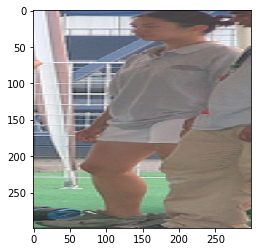

In [39]:
print(len(voc_paths_and_classes))
example = np.load(os.path.join(voc_paths_and_classes)[40000][0])
print(voc_paths_and_classes[40000])
plt.imshow(example)
plt.show()

### Inception v3モデルを読み込み、その出力層を変える

In [40]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [41]:
import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

reset_graph()

X = tf.placeholder(tf.float32, shape = [None, 299, 299, 3], name = 'X')
traning = tf.placeholder_with_default(False, shape = [])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes = 1001, is_training = traning)

inception_saver = tf.train.Saver()

/anaconda3/envs/ai_course/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [42]:
end_points['PreLogits']

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [43]:
prelogits = tf.squeeze(end_points['PreLogits'], axis = [1, 2])

In [44]:
n_outputs = 20

with tf.name_scope('new_output_layer'):
    voc_logits = tf.layers.dense(prelogits, n_outputs, name = 'voc_logits')

In [45]:
learning_rate = 0.001

y = tf.placeholder(tf.int32, shape = [None])

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = voc_logits, labels = y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate, momentum = 0.9, use_nesterov = True)
    voc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = 'voc_logits')
    training_op = optimizer.minimize(loss, var_list = voc_vars)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(voc_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [46]:
[v.name for v in voc_vars]

[u'voc_logits/kernel:0', u'voc_logits/bias:0']

### 学習データとテストデータの分割

In [58]:
from random import sample

def prepare_batch(voc_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(voc_paths_and_classes, batch_size)
    images = [np.load(path) for path, labels in batch_paths_and_classes]
    X_batch = 2 * np.stack(images) - 1 #inception expects colors ranging from -1 to 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype = np.int32)
    return X_batch, y_batch

In [67]:
voc_paths_and_classes_train = voc_paths_and_classes[:30000]
voc_paths_and_classes_validation = voc_paths_and_classes[30000:35000]
voc_paths_and_classes_test = voc_paths_and_classes[35000:]

In [68]:
print(len(voc_paths_and_classes_train))
print(len(voc_paths_and_classes_validation))
print(len(voc_paths_and_classes_test))

30000
5000
5138


In [69]:
X_batch, y_batch = prepare_batch(voc_paths_and_classes_train, batch_size = 5)

In [70]:
X_batch.shape

(5, 299, 299, 3)

In [71]:
y_batch.shape

(5,)

In [72]:
X_batch.dtype

dtype('float32')

In [73]:
y_batch.dtype

dtype('int32')

In [74]:
X_validation, y_validation = prepare_batch(voc_paths_and_classes_validation, batch_size = len(voc_paths_and_classes_validation))

In [75]:
X_validation.shape

(5000, 299, 299, 3)

In [76]:
y_validation.shape

(5000,)

### 早期打ち切りを実装した学習

In [66]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [ ]:
n_epochs = 1000
batch_size = 100
n_iterations_per_epoch = len(voc_paths_and_classes_train) // batch_size

best_loss_val = np.infty
check_interval = 140
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("Epoch", epoch, end = '')
        for iteration in range(n_iterations_per_epoch):
            if iteration % 3 == 0:
                print('.', end = '')
            X_batch, y_batch = prepare_batch(voc_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict = {X: X_batch, y: y_batch, traning: True})
            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict = {X: X_validation, y: y_validation})
                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1
        acc_train = accuracy.eval(feed_dict = {X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict = {X: X_validation, y: y_validation})
        print("Epoch {}, train accuracy: {:.4f}%, valid. accuracy: {:.4f}%, valid. best loss: {:.6f}".format(
                  epoch, acc_train * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print("Early stopping!!!")
            break
    if best_model_params:
        restore_model_params(best_model_params)
    save_path = saver.save(sess, "./voc_regionproposal_cnn")
                

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.